# AT1 - Australian Skills Classification (ASC) Text Analysis

### Table of Contents

1. Project Overview
2. Data Understanding
3. Data Analysis
4. Results and Discussion
5. Acknowledgements and References


#Project Overview


The Australian Government employs the use of the Australian Skills Classification (ASC) to consolidate the core competencies, specialist tasks and technology tools required for the country's occupations. Through the ASC, a common language of skills are made accessible, enabling any stakeholder to be able to identify and articulate the skills using a universal and comprehensive taxonomy.

This project aims to assess the strengths and weakness of the ASC using Natural Language Processing (NLP) Techniques. In addition, the project also aims to provide insight on what key skills are needed for data scientists in the future, and how AI might reshape future tasks.

# Data Understanding

## Data Loading



The project utilized two datasets: the first is an Excel workbook containing the Australian Skills Classification (ASC), which includes, among other things, a list of occupations, core competencies, specialist tasks, technology tools, and their definitions spread across eleven (11) worksheets. The second dataset is a zip file containing seventeen (17) comma-separated value (CSV) files extracted from the European Skills, Competences, Qualifications and Occupations (ESCO) ontology.

The worksheets in the ASC workbook were initially loaded as separate dataframes, with each sheet covering different aspects of the data. The dataset was then narrowed down to the following relevant dataframes: 'Occupation_descriptions', 'Core_competency_descriptions', 'Specialist_tasks_hierarchy', 'Tech_tools_hierarchy', 'Core_competencies', 'Specialist_tasks_data', and 'Technology_tools'. These were considered the most relevant to assess the language used for the listed jobs, including job descriptions, required skills, and tools.

For the ESCO dataset, all the CSV files were loaded as dataframes. A quick overview of the content revealed that the occupationSkillsRelations_en dataframe contains connections between unique ESCO-identified jobs and their associated skills, represented by ESCO URLs. The actual job titles and skill descriptions linked to these URLs can be found in the occupations_EN and skills_EN dataframes. Furthermore, the European Commission identified broader skill groups, such as Research, Digital Competence, Digital, Green, Language, and Transversal skills, which were listed in separate CSV files. A detailed examination of these files, along with the skills_EN dataframe, confirmed that the broader skill groups were already incorporated in the latter.


In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
import pandas as pd

file_path = "/content/drive/My Drive/NLP/AT1/Australian Skills Classification - December 2023.xlsx"

In [27]:
!pip install pyldavis
!pip install umap-learn

Throughout the project, various packages were utilised to load, process, and visualise. The Key Packages used are:

- NLTK: for stopword, ngrams (used to create a custom bigram/trigram function)
- Gensim: for preprocessing of sentences (simple_preprocess function), training of models used to extract the most common bigrams (Phrases/Phraser), and topic modelling (LDAmodel)
- spacy: for lemmatization and named-entity recognition (NER)
- tqdm: for large text processing
- sklearn: for cosine similarity computation, conversion of text to numerical values (tfidvectorizer), and clustering (kmeans)
- umap: for dimensionality reduction
- wordcloud/matplotlibe/networkx: visualization

In [28]:
#general functions
import numpy as np
import random
import os
import glob


#processing of tokens
import nltk
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

from nltk.corpus import stopwords
from collections import Counter
from nltk import ngrams
from nltk import bigrams
from gensim.utils import simple_preprocess
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from gensim.corpora import Dictionary
import spacy
from tqdm import tqdm

#text/data manipulation
import string
import re
from textblob import Word

#text relationship
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

#visualisation
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MaxNLocator
import matplotlib.colors as mcolors
from nltk.util import bigrams

#topic modelling
from gensim.models.ldamodel import LdaModel
import pyLDAvis
from pyLDAvis.gensim import prepare

#clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from umap import UMAP

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [29]:
# Load Excel file
file_path = "/content/drive/My Drive/NLP/AT1/Australian Skills Classification - December 2023.xlsx"  # Replace with your file path
xls = pd.ExcelFile(file_path)

# Loop through each sheet and create a DataFrame with the sheet name as the variable name
for sheet_name in xls.sheet_names:
    # Replace spaces and special characters in sheet names for valid variable names
    df_name = sheet_name.strip().replace(" ", "_").replace("-", "_")
    globals()[df_name] = xls.parse(sheet_name)

In [30]:
df_analysis = ['Occupation_descriptions', 'Core_competency_descriptions', 'Specialist_tasks_hierarchy', 'Tech_tools_heirarchy', 'Core_competencies', 'Specialist_tasks_data', 'Technology_tools']

In [31]:
# Define the folder containing the CSV files
folder_path = '/content/drive/My Drive/NLP/AT1/ESCO/'  # Adjust the path as necessary

# Get a list of all CSV files in the folder
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# Create a dictionary to store DataFrames
dfs = {}

# Loop through each CSV file and load it into a DataFrame
for file in csv_files:
    file_path = os.path.join(folder_path, file)
    df_name = file.replace('.csv', '')  # Use the file name (without extension) as the DataFrame key
    dfs[df_name] = pd.read_csv(file_path)

# Print the names, shapes, and the first 5 rows of all loaded DataFrames
for name, df in dfs.items():
    print(f"{name}: {df.shape}")

broaderRelationsOccPillar_en: (3652, 4)
languageSkillsCollection_en: (359, 10)
occupationSkillRelations_en: (129004, 4)
digCompSkillsCollection_en: (25, 10)
digitalSkillsCollection_en: (1284, 10)
conceptSchemes_en: (19, 7)
greenSkillsCollection_en: (591, 10)
broaderRelationsSkillPillar_en: (20822, 4)
occupations_en: (3039, 14)
ISCOGroups_en: (619, 8)
skills_en: (13939, 13)
skillsHierarchy_en: (640, 14)
skillSkillRelations_en: (5818, 5)
skillGroups_en: (640, 11)
transversalSkillsCollection_en: (95, 10)
researchOccupationsCollection_en: (122, 8)
researchSkillsCollection_en: (40, 10)


## Exploratory Data Analysis


### Australian Skills Classification


The ASC used in the study covers 1,650 unique ANZSCO Titles under 1,178 different ANZSCO Codes on five (5) Occupation Types. Highly-related/similar job titles as deemed by the Australian Bureau of Statistics (ABS) were grouped under the same ANZSCO code.   

The ASC also listed 10 Core Competencies scored from 1 to 10 split under three proficiency levels (1-3 Basic, 4-7 Intermediate, 8-10 High) with each having a unique anchor value (totalling to 100 unique values across all competencies). The document also provided 1,686 differring specialist skills statements that can be grouped under 272 specialist clusters which can be further compiled under 31 cluster families. In addition, 94 technology tools were enumerated which can be grouped under 27 broader technology tool categories.

In [32]:
for df_name in df_analysis:
    print(f"\n--- DataFrame: {df_name} ---")
    print(globals()[df_name].info())  # Print .info() for each DataFrame


--- DataFrame: Occupation_descriptions ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1650 entries, 0 to 1649
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Occupation Type     1650 non-null   object
 1   ANZSCO Code         1650 non-null   int64 
 2   Sub-Profile Code    472 non-null    object
 3   ANZSCO Title        1650 non-null   object
 4   ANZSCO Description  1650 non-null   object
dtypes: int64(1), object(4)
memory usage: 64.6+ KB
None

--- DataFrame: Core_competency_descriptions ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Core Competency              100 non-null    object
 1   Core Competency Description  100 non-null    object
 2   Score                        100 non-null    int64 
 3   Proficiency Leve

In [33]:
# Get the unique count of 'ANZSCO Code' and 'Occupation Type'
unique_anzsco_codes = Occupation_descriptions['ANZSCO Code'].nunique()
unique_occupation_types = Occupation_descriptions['Occupation Type'].nunique()

# Print the results
print(f"Unique ANZSCO Code Count: {unique_anzsco_codes}")
print(f"Unique Occupation Type Count: {unique_occupation_types}")

Unique ANZSCO Code Count: 1178
Unique Occupation Type Count: 5


In [34]:
Occupation_descriptions[['ANZSCO Title', 'ANZSCO Description']].describe()

,ANZSCO Title,ANZSCO Description
count,1650,1650
unique,1650,1650
top,Chief Executives and Managing Directors,Chief Executives and Managing Directors determ...
freq,1,1


In [35]:
Core_competency_descriptions[['Core Competency', 'Core Competency Description', 'Proficiency Level', 'Anchor Value']].describe()

,Core Competency,Core Competency Description,Proficiency Level,Anchor Value
count,100,100,100,100
unique,10,10,3,100
top,Digital engagement,Identifying and using technology (including ha...,Intermediate,Name and identify the purpose of familiar digi...
freq,10,10,40,1


In [36]:
Specialist_tasks_hierarchy.describe()

,Specialist Task,Specialist Cluster,Cluster Family,Skill Statement
count,1686,1686,1686,1686
unique,1686,272,31,1686
top,Advise others on farming or forestry operation...,"Inspect, test or maintain equipment or systems",Health and care,Provide advice about managing farms and forest...
freq,1,25,150,1


In [37]:
Tech_tools_heirarchy.describe()

,Technology Tool Category,Technology Tool Category Description,Technology Tool,Technology Tool Description,Technology Tool Extended Description
count,94,94,94,94,94
unique,27,26,94,94,94
top,IT Infrastructure and management technologies,"Software, hardware, and other tools for the de...",Collaborative news production platforms,Software used to create and manage news conten...,Collaborative news production platforms encomp...
freq,11,11,1,1,1


The ASC dataset has missing values in the 'Sub-Profile Code' column of its worksheets which is appropriate since not all job titles were assigned with a specific sub-profile code. There are also missing values in the 'Emerging/Trending Flag' columns and the '% of time spent on task/cluster/family' Columns which might indicate either lack of significant data (e.g., not enough information on the time spent for a particular task/or not enough information whether a task is emerging/trending) or the specific task is not emerging or trending at all. These columns were mostly ignored for the succeeding steps ignored to compile the general information on each job title listed under the ASC.

In [38]:
for df_name in df_analysis:
    df = globals()[df_name]
    print(f"\n--- DataFrame: {df_name} ---")

    # Get the columns with null values
    null_columns = df.isna().sum()

    # Filter to show only columns with null values
    null_columns = null_columns[null_columns > 0]

    if not null_columns.empty:
        print(null_columns)


--- DataFrame: Occupation_descriptions ---
Sub-Profile Code    1178
dtype: int64

--- DataFrame: Core_competency_descriptions ---

--- DataFrame: Specialist_tasks_hierarchy ---

--- DataFrame: Tech_tools_heirarchy ---

--- DataFrame: Core_competencies ---
Sub-Profile Code    11030
dtype: int64

--- DataFrame: Specialist_tasks_data ---
Sub-Profile Code               23934
% of time spent on task         6516
Emerging/\nTrending Flag       29048
 % of time spent on cluster     6516
% of time spent on family       6516
dtype: int64

--- DataFrame: Technology_tools ---
Sub-Profile Code          4461
Emerging/Trending Flag    5320
dtype: int64


A large number of the ANZSCO job titles have two or more words. The descriptions provided mostly have twenty to forty words, with jobs under the 'Specialisation' occupation type as the outlier with a description length of around 80 words on average. This might be an indication that these jobs require more explanation to be differentiated from other job titles or the ABS deem that most jobs can be sufficiently specified using around twenty words.

In [39]:
def word_count(text):
    wc = len(text.split())
    return wc

In [40]:
Occupation_descriptions['desc_word_count'] = Occupation_descriptions['ANZSCO Description'].apply(word_count)
Occupation_descriptions['title_word_count'] = Occupation_descriptions['ANZSCO Title'].apply(word_count)

array([[<Axes: title={'center': 'title_word_count'}>]], dtype=object)

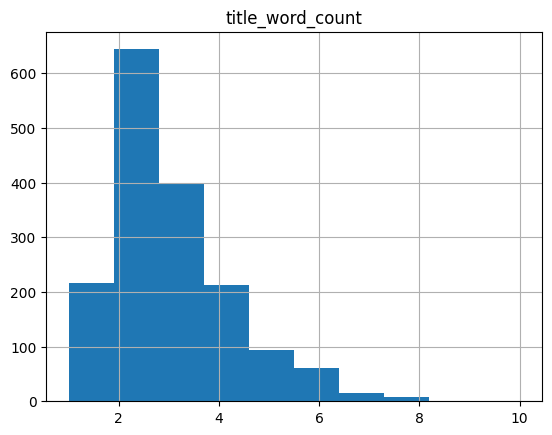

In [41]:
Occupation_descriptions[['title_word_count']].hist(bins = 10)

<Axes: >

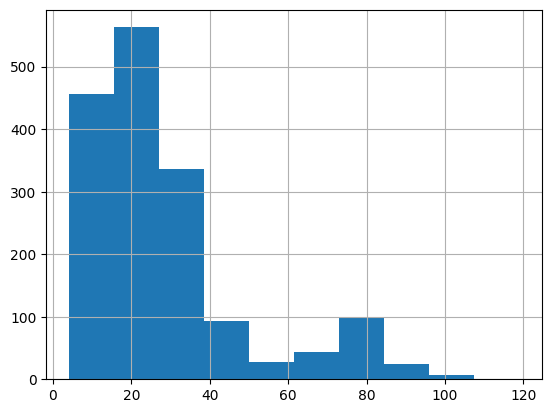

In [42]:
Occupation_descriptions['desc_word_count'].hist(bins = 10)

<ipython-input-43-725faadd1246>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x = "Occupation Type",


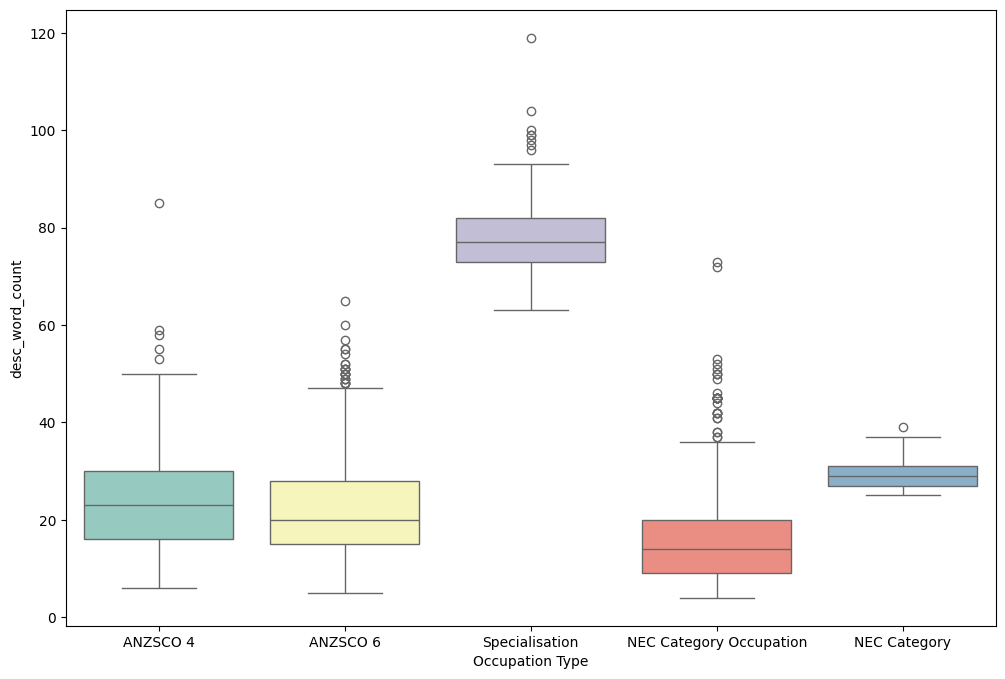

In [43]:
# Set the figure size
plt.figure(figsize=(12, 8))  # Adjust the size as needed

sns.boxplot(x = "Occupation Type",
            y = "desc_word_count",
            palette='Set3',
            data =Occupation_descriptions);

Exploring the most common word used to differentiate the jobs using word cloud, it appears that the ASC have many titles that contain the word 'Manager', 'Worker', and 'Technician'.

In [44]:
OD_ANZSCODescription = Occupation_descriptions['ANZSCO Description'].to_string()
OD_ANZSCOtitle = Occupation_descriptions['ANZSCO Title'].to_string()

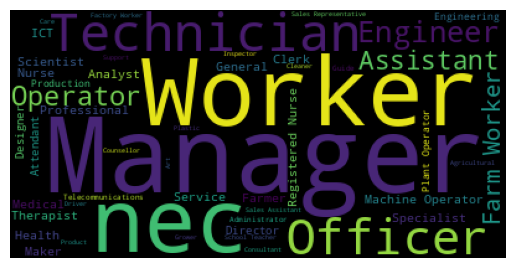

In [45]:
wordcloud_title = WordCloud(max_words=50).generate(OD_ANZSCOtitle)

plt.imshow(wordcloud_title)
plt.axis("off")
plt.show()

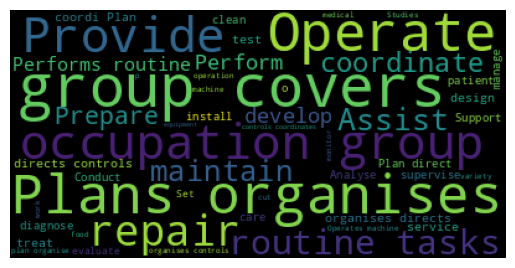

In [46]:
wordcloud_desc = WordCloud(max_words=50).generate(OD_ANZSCODescription)

plt.imshow(wordcloud_desc)
plt.axis("off")
plt.show()

Another exploration of the 'Occupation_description' shows that the words 'required', 'registration', and 'licensing' are among the top words used to describe the jobs listed under the ASC. This might indicate that a number of jobs are identified to have actual requirements, registration, or license.

In [47]:
def wordBarGraphFunction(df,column,title):
    topic_words = [ z.lower() for y in
                       [ x.split() for x in df[column] if isinstance(x, str)]
                       for z in y]
    word_count_dict = dict(Counter(topic_words))
    popular_words = sorted(word_count_dict, key = word_count_dict.get, reverse = True)
    popular_words_nonstop = [w for w in popular_words if w not in stopwords.words("english")]
    plt.barh(range(50), [word_count_dict[w] for w in reversed(popular_words_nonstop[0:50])])
    plt.yticks([x + 0.5 for x in range(50)], reversed(popular_words_nonstop[0:50]))
    plt.title(title)
    plt.show()

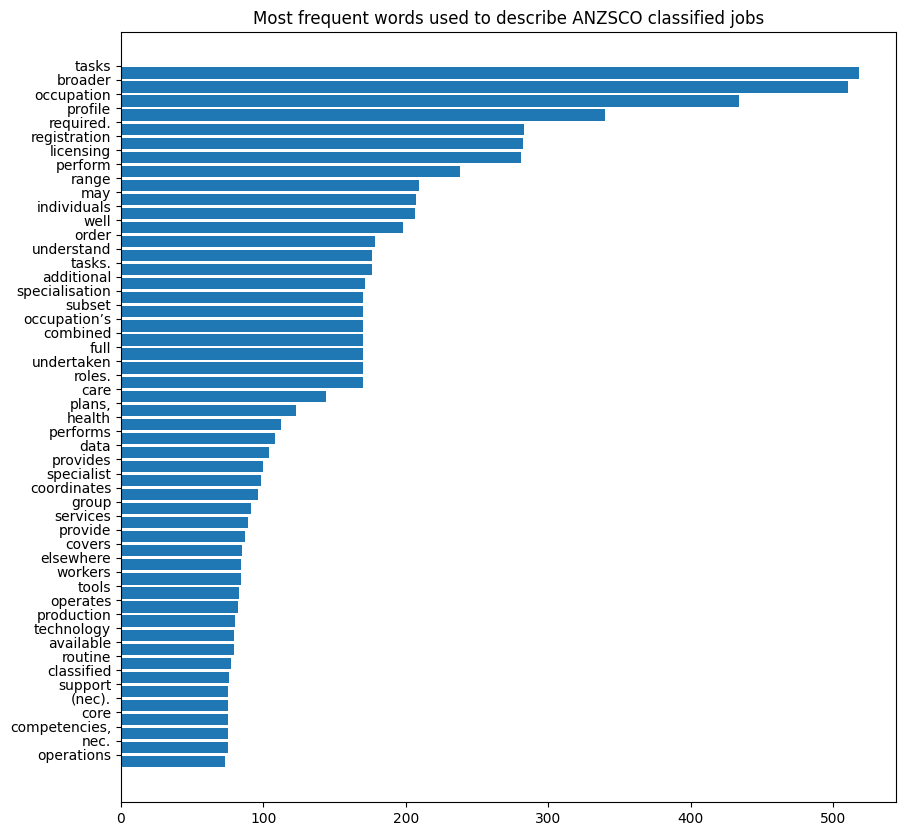

In [48]:
plt.figure(figsize=(10,10))
wordBarGraphFunction(Occupation_descriptions,'ANZSCO Description',"Most frequent words used to describe ANZSCO classified jobs")

Moreover, it appears that within the same dataframe, around 7% of jobs were listed twice in both singular and plural forms (e.g., Aquaculture Farmer/Aquaculture Farmers), mostly occurring under ANZSCO 4 and ANZSCO 6 classifications (e.g., Aquaculture Farmers under ANZSCO 4 and Aquaculture Farmer under ANZSCO 6). While this might be reasonable—since ANZSCO 4 represents Unit Groups and ANZSCO 6 specifies individual occupations within those groups—it still introduces potential redundancies, particularly in cases where only one job exists within a unit group. This could affect classification consistency and lead to unnecessary repetition across the dataset.

In [49]:
# Normalize function to handle singular and plural forms
def normalize_title(title):
    # Convert title to lowercase and remove "s" from the end (if it exists)
    normalized = title.lower().rstrip('s')
    return normalized

# Assuming you have a DataFrame called 'Occupation_descriptions'
titles = Occupation_descriptions['ANZSCO Title']

# Set to track the normalized titles
normalized_titles_set = set()
singular_plural_pairs = 0
singular_plural_titles = []

# Loop through all titles to count singular-plural pairs
for title in titles:
    normalized_title = normalize_title(title)

    # If the normalized title is already in the set, it's a singular-plural pair
    if normalized_title in normalized_titles_set:
        singular_plural_pairs += 1
        singular_plural_titles.append(title)
    else:
        # Add the normalized title to the set (whether singular or plural)
        normalized_titles_set.add(normalized_title)

# Calculate the total number of titles
total_titles = len(titles)

# Calculate the percentage of singular-plural pairs
percentage_singular_plural = (singular_plural_pairs / total_titles) * 100

# Print the results
print(f"Total Titles: {total_titles}")
print(f"Singular-Plural Pairs: {singular_plural_pairs}")
print(len(normalized_titles_set))
print(f"Percentage of Singular-Plural Pairs: {percentage_singular_plural:.2f}%")
print(singular_plural_titles)

Total Titles: 1650
Singular-Plural Pairs: 109
1541
Percentage of Singular-Plural Pairs: 6.61%
['Aquaculture Farmer', 'Corporate Services Manager', 'Finance Manager', 'Human Resource Manager', 'Policy and Planning Manager', 'Research and Development Manager', 'Engineering Manager', 'Manufacturer', 'Child Care Centre Manager', 'School Principal', 'Licensed Club Manager', 'Conference and Event Organiser', 'Photographer', 'Training and Development Professional', 'Economist', 'Librarian', 'Public Relations Professional', 'Interior Designer', 'Urban and Regional Planner', 'Electrical Engineer', 'Electronics Engineer', 'Veterinarian', 'Early Childhood (Pre-primary School) Teacher', 'Primary School Teacher', 'Secondary School Teacher', 'Occupational Therapist', 'Physiotherapist', 'Podiatrist', 'Anaesthetist', 'Psychiatrist', 'Nurse Manager', 'Barrister', 'Solicitor', 'Social Worker', 'Safety Inspector', 'Automotive Electrician', 'Sheetmetal Worker', 'Panelbeater', 'Vehicle Painter', 'Floor Fin

In [50]:
plural_titles = [Word(title).pluralize() for title in singular_plural_titles]

# Combine both singular and plural titles
sp_titles = set(singular_plural_titles + plural_titles)

# Filter the Occupation_descriptions DataFrame
df_sp = Occupation_descriptions[Occupation_descriptions['ANZSCO Title'].isin(sp_titles)]

# Reset index for clean output
df_sp.reset_index(drop=True, inplace=True)

# Display the extracted DataFrame
print(df_sp['Occupation Type'].value_counts())

Occupation Type
ANZSCO 6    109
ANZSCO 4    106
Name: count, dtype: int64


To prepare the dataset for further analysis, a pipeline for word processing was implemented, as follows:

- Tokenisation: the sentences are split into word tokens using the 'simple_preprocess' function from the Gensim package which provides basic text cleaning including punctuation removal.
- Stopword Removal: from the resulting tokens, stopwords (e.g., word tokens that little meaningful contribution to the text) were removed. The NLTK stopwords list were utilised as reference.
- Bigram Creation: in order to preserve meaning of some of the word tokens, bigram modelling was performed using the 'Phrases' and 'Phraser' functions from the Gensim package to extract the most common paired expression across the dataset.
- Lemmatization: After applying bigram creation, the resulting word tokens are then converted into its root form (lemma). This process was utilised instead of stemming since it potentially preserves more of the core meaning of the text as compared to the latter process. For this project, the team opted to utilise the spaCy for a more dynamic conversion to lemma tokens as compared to the NLTK package used in stopword removal.

In [51]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def tokenize(text):
    # Apply the simple_preprocess function
    text = simple_preprocess(str(text), deacc=True)
    return text

# Function to remove stopwords
def remove_stopword(text):
    tokens = []
    for token in text:
        if token not in stop_words:
            tokens.append(token)
    return tokens

# Function to lemmatize the tokens
def lemmatize(tokens, allowed_postags=["NOUN", "ADJ", "VERB"]):
    text = " ".join(tokens)
    text = nlp(text)
    lemmatized_tokens = []

    for token in text:
        if token.pos_ in allowed_postags:
            lemmatized_tokens.append(token.lemma_)

    return lemmatized_tokens

# Function to create bigrams
def create_bigrams(text):
    return bigram_model[text]

# Function to create trigrams
def create_trigrams(text):
    return trigram_model[bigram_model[text]]

In [52]:
OD_desc_token1 = Occupation_descriptions["ANZSCO Description"].apply(tokenize)

bigram = Phrases(OD_desc_token1, min_count=3, threshold=100)
bigram_model = Phraser(bigram)

print("Sample bigrams:")
print(", ".join(list(bigram.export_phrases().keys())[:5]))

# Collect the trigrams
trigram = Phrases(bigram[OD_desc_token1], threshold=100)
trigram_model = Phraser(trigram)

print("Sample trigrams:")
print(", ".join(list(trigram.export_phrases().keys())[:5]))

Sample bigrams:
plan_organise, organise_direct, major_functions, farming_operations, aquatic_stock
Sample trigrams:
plan_organise, managers_plan_organise, plan_organise_direct, direct_control, farming_operations


In [54]:
stop_words = stopwords.words('english')

tokenized_data = OD_desc_token1

# Apply function to remove the stopwords
tokenized_data_desc = [remove_stopword(text) for text in tokenized_data]

# Create the bigrams
bigram_data_desc = [create_bigrams(text) for text in tokenized_data_desc]

# Lemmatize the text
lemmatized_data_desc = [lemmatize(text) for text in bigram_data_desc]

OD_title_token1 = Occupation_descriptions["ANZSCO Title"].apply(tokenize)

tokenized_data1 = OD_title_token1

# Apply function to remove the stopwords
tokenized_data_title = [remove_stopword(text) for text in tokenized_data1]

# Create the bigrams
bigram_data_title = [create_bigrams(text) for text in tokenized_data_title]

# Lemmatize the text
lemmatized_data_title = [lemmatize(text) for text in bigram_data_title]

The unique word count is computed from the ASC job descriptions to assess the diversity of vocabulary used across the classification after the implementation of the word processing pipeline. The analysis reveals that 12.19% of the total words used in the job descriptions are unique. This indicates a relatively high level of standardization in the language across the document, which may contribute to readability and consistency. However, it could also suggest that the job descriptions may be too similar to one another, with repetitive phrasing or overlapping terminology, potentially reducing the distinctiveness of each occupation’s description.

Applying the unique word count to the job titles reveals a higher percentage (32.21%), which may indicate that the job titles are more generalized. This could be advantageous as it allows the classification to encompass a broader range of jobs in the Australian market, making it more inclusive and reflective of diverse job titles across industries.

In [55]:
# Flatten all words into a single list
all_desc_words = [word for text in lemmatized_data_desc for word in text]
all_title_words = [word for text in lemmatized_data_title for word in text]

# Compute total words and unique words
total_desc_words = len(all_desc_words)
unique_desc_words = len(set(all_desc_words))

total_title_words = len(all_title_words)
unique_title_words = len(set(all_title_words))

# Compute percentage of unique words
desc_unique_pct = (unique_desc_words / total_desc_words) * 100 if total_desc_words > 0 else 0
title_unique_pct = (unique_title_words / total_title_words) * 100 if total_title_words > 0 else 0

# Print results
print(f"Total Unique Description Word Count: {unique_desc_words}")
print(f"Total Words in Descriptions: {total_desc_words}")
print(f"Total Unique Description Word Percentage: {desc_unique_pct:.2f}%\n")

print(f"Total Unique Title Word Count: {unique_title_words}")
print(f"Total Words in Titles: {total_title_words}")
print(f"Total Unique Title Word Percentage: {title_unique_pct:.2f}%")

Total Unique Description Word Count: 3320
Total Words in Descriptions: 27234
Total Unique Description Word Percentage: 12.19%

Total Unique Title Word Count: 1165
Total Words in Titles: 3617
Total Unique Title Word Percentage: 32.21%


In [56]:
def get_top_ngrams(text, n, top_k):

    # Generate n-grams
    n_grams = list(ngrams(text, n))

    # Count the frequency of each n-gram
    n_gram_freq = Counter(n_grams)

    # Get the top k most frequent n-grams
    top_n_grams = n_gram_freq.most_common(top_k)

    return top_n_grams

An exploration of the frequent bigrams used in job titles reveals that many of the paired words reflect jobs involving the physical operation of plant, property, and equipment (e.g., machine operator, farm worker, plant operator). This observation may provide insight into the availability of such jobs during the creation of the ASC, suggesting that roles focused on physical operations may have been more prominent on that time. This also provides additional information with respect to the wordcloud generated for the job titles since the most common word 'manager' and 'technician' did not appear in the most common bigrams, technician and manager titles might have been more spread out across different fields.

In [57]:
# Get top 5 bigrams
top_bigrams_ODtitle = get_top_ngrams(all_title_words, 2, 5)

print("Top 5 Bigrams: Title")
for bigram, count in top_bigrams_ODtitle:
    print(f"{bigram}: {count}")

Top 5 Bigrams: Title
('farm', 'worker'): 31
('plant', 'operator'): 17
('factory', 'worker'): 12
('manager', 'manager'): 9
('sale', 'representative'): 9


On the other hand, a bigram and trigram analysis of the job descriptions highlights the frequent use of the word "broad." This may be attributed to the inclusion of jobs under the N.E.C. (Not Elsewhere Classified) category, as seen in the appearance of 'nec' in the job title wordcloud. This category aims to capture a wide range of occupations that don't fit into specific classifications, or to job descriptions with a broader scope of tasks. Additionally, the appearance of "registration" and "licensing" in the bigram list reinforces the insights observed in the job description word cloud, suggesting that many of the jobs in the list require registration or licensing.

In [58]:
# Get top 5 bigrams
top_bigrams_ODdesc = get_top_ngrams(all_desc_words, 2, 5)

# Get top 5 trigrams
top_trigrams_ODdesc = get_top_ngrams(all_desc_words, 3, 5)

# Print results
print("Top 5 Bigrams: Desc")
for bigram, count in top_bigrams_ODdesc:
    print(f"{bigram}: {count}")

print("\nTop 5 Trigrams: Desc")
for trigram, count in top_trigrams_ODdesc:
    print(f"{trigram}: {count}")

Top 5 Bigrams: Desc
('broad', 'occupation'): 356
('registration', 'licensing'): 281
('licensing', 'require'): 281
('perform', 'broad'): 170
('occupation', 'task'): 170

Top 5 Trigrams: Desc
('registration', 'licensing', 'require'): 281
('perform', 'broad', 'occupation'): 170
('broad', 'occupation', 'task'): 170
('profile', 'combine', 'broad'): 170
('profile', 'order', 'understand'): 170


The creation of the bigram network map for job descriptions suggests that certain job groups can potentially be identified based on distinct bigram relationships. For example, job descriptions containing terms like 'plans', 'organise', 'direct', and 'controls' often exhibit strong bigram connections, which could be indicative of supervisory or managerial roles. Similarly, job descriptions with bigrams such as 'require', 'specialisation', 'licensing', and 'registration' may align with licensed professional roles. These bigram patterns may help in distinguishing and classifying roles based on their responsibilities and required qualifications.

This observation could suggest a consistency of word usage across different job groups within the ASC, potentially improving the clarity and relatability of job descriptions.

In [59]:
bigrams_desc = list(bigrams(all_desc_words))

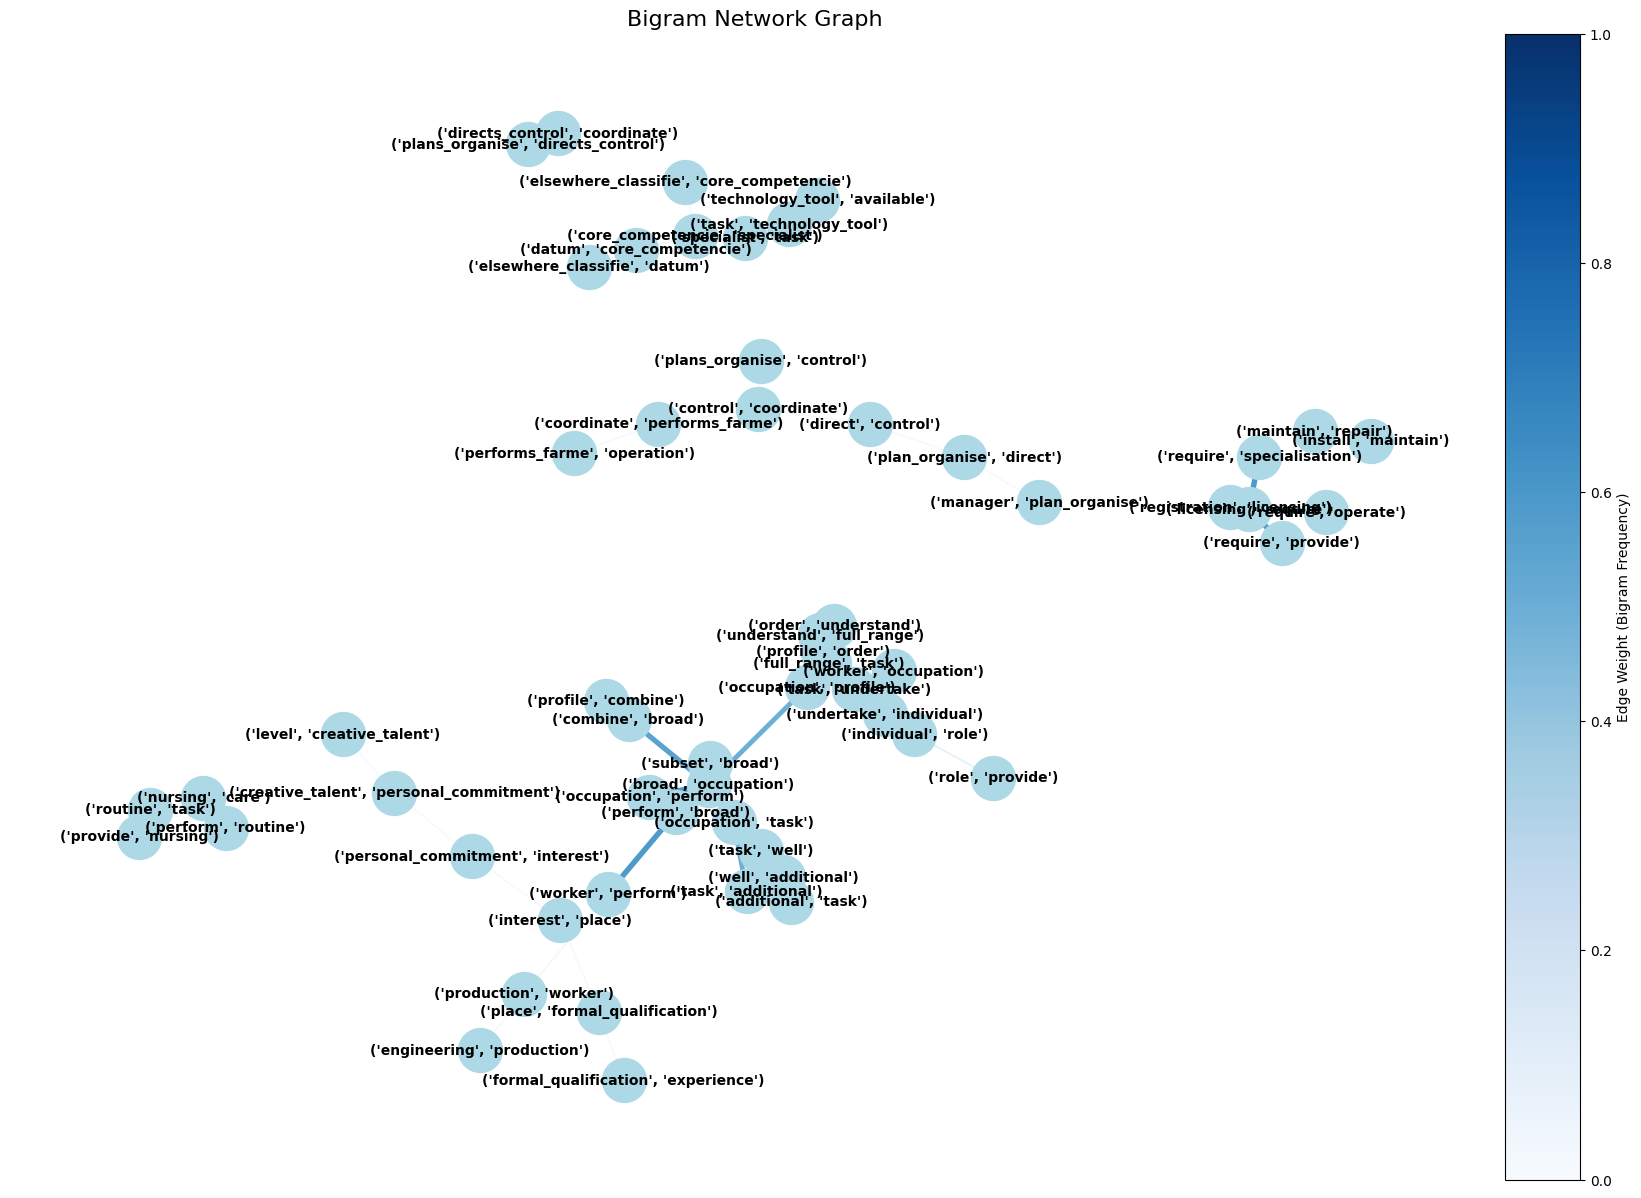

In [60]:
def plot_bigram_network(tokens, n=50):
    # Get bigrams
    bi_grams = list(bigrams(tokens))

    # Count bigram frequencies
    bigram_freq = Counter(bi_grams)

    # Create network graph
    G = nx.Graph()

    # Initialize empty lists to store edge widths and colors
    edge_width = []
    edge_color = []

    for bigram, count in bigram_freq.most_common(n):
        G.add_edge(bigram[0], bigram[1], weight=count)
        edge_width.append(count)
        edge_color.append(count)

    # Normalize edge widths for better visualization
    edge_width = np.array(edge_width, dtype=float)
    edge_width = 1 + (edge_width - edge_width.min()) * 5 / (edge_width.max() - edge_width.min())

    # **Fix: Normalize edge_color for colormap**
    edge_color = np.array(edge_color, dtype=float)
    edge_color = (edge_color - edge_color.min()) / (edge_color.max() - edge_color.min())  # Normalize between 0 and 1

    # Plot
    plt.figure(figsize=(16, 12))
    pos = nx.spring_layout(G, k=0.5, iterations=50)

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=1000, node_color='lightblue')

    # Draw edges with normalized colors
    edges = nx.draw_networkx_edges(G, pos, width=edge_width, edge_color=edge_color, edge_cmap=plt.cm.Blues)

    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold")

    # Set the title, remove the axis, and adjust the layout
    plt.title('Bigram Network Graph', fontsize=16)
    plt.axis('off')
    plt.tight_layout()

    # Add a colorbar to show the weight scale
    divider = make_axes_locatable(plt.gca())
    cax = divider.append_axes("right", size="5%", pad=0.05)
    sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues, norm=plt.Normalize(vmin=0, vmax=1))  # Now normalized
    sm.set_array([])
    cbar = plt.colorbar(sm, cax=cax)
    cbar.set_label('Edge Weight (Bigram Frequency)', fontsize=10)

    plt.show()

# Input is your list of tokenized words
plot_bigram_network(bigrams_desc)

In [61]:
tokenized_data_desc_str = [' '.join(tokens) for tokens in tokenized_data_desc]

# Vectorize the cleaned descriptions using TF-IDF
vectorizer = TfidfVectorizer()
tfidf_matrix_desc = vectorizer.fit_transform(tokenized_data_desc_str)

# Compute cosine similarity between rows
cos_sim_matrix_desc = cosine_similarity(tfidf_matrix_desc)

In [63]:
# Define a threshold for similarity
threshold = 0.8

# Get the indices of the highly similar pairs
similar_pairs_desc = np.where(cos_sim_matrix_desc > threshold)

# Create a dictionary to store the count of high similarity and similar titles for each 'ANZSCO Title'
similarity_count_desc = {}
similar_titles_desc = {}

# Loop through the pairs and count the similarities
for i, j in zip(*similar_pairs_desc):
    if i != j:  # Avoid comparing the row with itself
        title_i = Occupation_descriptions['ANZSCO Title'].iloc[i]
        title_j = Occupation_descriptions['ANZSCO Title'].iloc[j]

        # Update the count for each ANZSCO Title pair
        similarity_count_desc[title_i] = similarity_count_desc.get(title_i, 0) + 1
        similarity_count_desc[title_j] = similarity_count_desc.get(title_j, 0) + 1

        # Track the similar titles for each 'ANZSCO Title'
        if title_i not in similar_titles_desc:
            similar_titles_desc[title_i] = []
        if title_j not in similar_titles_desc:
            similar_titles_desc[title_j] = []

        similar_titles_desc[title_i].append(title_j)
        similar_titles_desc[title_j].append(title_i)

# Sort the titles based on the number of similarities (highest first)
sorted_titles_desc = sorted(similarity_count_desc.items(), key=lambda x: x[1], reverse=True)

# Set to keep track of processed titles to avoid repeating them
processed_titles_desc = set()
title_isolated_desc = []

# Print the top titles with high similarity, ensuring no repeats
print("Top ANZSCO Titles with high similarity:")

for title, count in sorted_titles_desc:
    if title in processed_titles_desc:
        continue  # Skip if this title has already been processed

    # Print the title and its similarity count
    print(f"\nTitle: {title} - Similarity Count: {int(count/2)}")
    title_isolated_desc.append(title)

    # Get the similar titles, removing duplicates using a set
    similar_titles_desc_set = set(similar_titles_desc[title])

    # Print all similar titles for the current title
    print(f"Similar Titles: {', '.join(similar_titles_desc_set)}")

    # Add this title and its similar titles to the processed set to avoid repeating them
    processed_titles_desc.add(title)
    processed_titles_desc.update(similar_titles_desc_set)

Top ANZSCO Titles with high similarity:

Title: Coffee Grower - Similarity Count: 9
Similar Titles: Hop Farmer, Mushroom Grower, Alpaca Farmer, Tree Farmer, Emu Farmer, Ginger Farmer, Crocodile Farmer, Llama Farmer, Ostrich Farmer

Title: Engineering Surveyor - Similarity Count: 3
Similar Titles: Mine Surveyor, Photogrammetric Surveyor, Hydrographic Surveyor

Title: Music Teacher (Private Tuition) - Similarity Count: 3
Similar Titles: Drama Teacher (Private Tuition), Art Teacher (Private Tuition), Dance Teacher (Private Tuition)

Title: Clothing Sales Assistant - Similarity Count: 3
Similar Titles: Cosmetic Sales Assistant, Hardware Sales Assistant, Fast Food Sales Assistant

Title: Goat Herder - Similarity Count: 3
Similar Titles: Ostrich Farm Worker, Deer Farm Worker, Emu Farm Worker

Title: Middle School Teacher / Intermediate School Teacher - Similarity Count: 2
Similar Titles: Middle School Teachers / Intermediate School Teachers, Secondary School Teacher

Title: Specialist Manage

Diving deeper into this insight, a cosine similarity matrix was computed across the job descriptions to identify highly similar job titles (those with 80%+ similarity in the job description). The resulting similar titles were then checked to see if they belonged to the same group. This process revealed a consistent pattern in the descriptions of similar job titles, enhancing their relatability and suggesting stronger connection between roles classified under the same group.

<ipython-input-66-713edb50b671>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Similarity Count', y='ANZSCO Title', data=df_similarity, palette=colors)


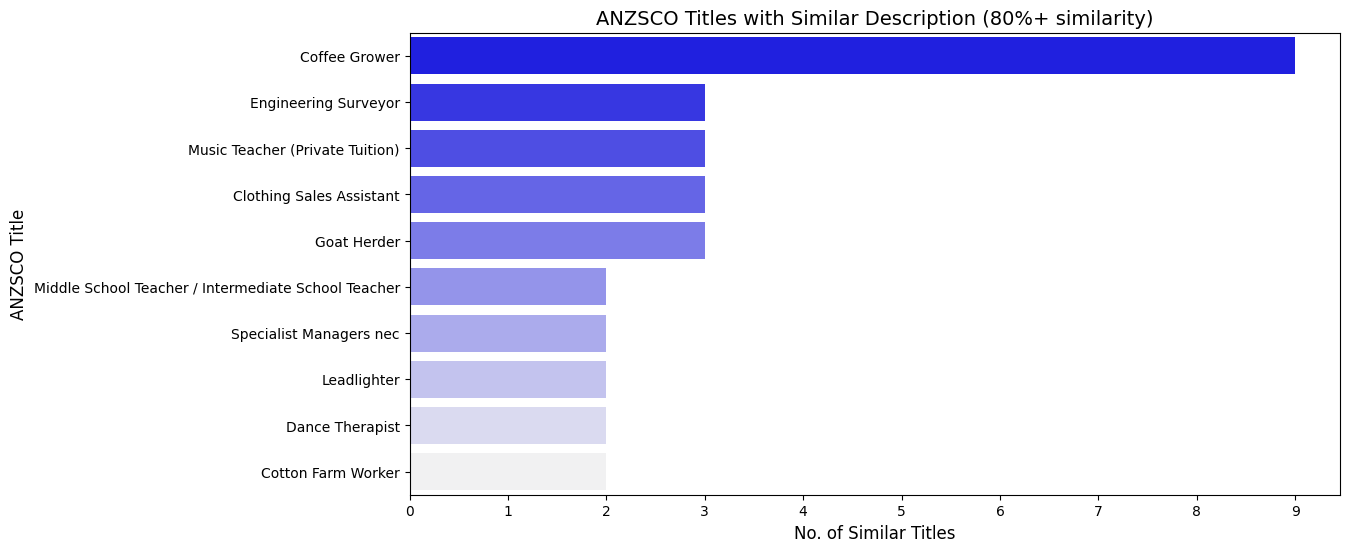

In [66]:
df_similarity0 = pd.DataFrame(sorted_titles_desc, columns=['ANZSCO Title', 'Similarity Count'])

# Filter to keep only the first occurrence of each processed title
df_similarity = df_similarity0[df_similarity0['ANZSCO Title'].isin(title_isolated_desc)]

# Select the top 10 highest similarity counts
df_similarity = df_similarity.head(10)

# Divide 'Similarity Count' by 2 and ensure the result is an integer
df_similarity['Similarity Count'] = (df_similarity['Similarity Count'] / 2).astype(int)

# Create a red-to-light-red color palette
colors = sns.light_palette("blue", reverse=True, n_colors=len(df_similarity))

# Plot horizontal bar chart with the custom red-to-light-red palette
plt.figure(figsize=(12, 6))
sns.barplot(x='Similarity Count', y='ANZSCO Title', data=df_similarity, palette=colors)

# Title and labels
plt.title('ANZSCO Titles with Similar Description (80%+ similarity)', fontsize=14)
plt.xlabel('No. of Similar Titles', fontsize=12)
plt.ylabel('ANZSCO Title', fontsize=12)

# Format x-axis to show integer values only
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

# Show the plot
plt.show()

In [67]:
merged_df_desc = pd.merge(df_similarity0, Occupation_descriptions[['ANZSCO Title', 'Occupation Type', 'ANZSCO Code', 'Sub-Profile Code']], on='ANZSCO Title', how='left')
merged_df_desc.head(14)

,ANZSCO Title,Similarity Count,Occupation Type,ANZSCO Code,Sub-Profile Code
0,Coffee Grower,18,NEC Category Occupation,121699,N01
1,Ginger Farmer,18,NEC Category Occupation,121699,N02
2,Hop Farmer,18,NEC Category Occupation,121699,N03
3,Mushroom Grower,18,NEC Category Occupation,121699,N04
4,Alpaca Farmer,16,NEC Category Occupation,121399,N01
5,Crocodile Farmer,16,NEC Category Occupation,121399,N02
6,Emu Farmer,16,NEC Category Occupation,121399,N04
7,Llama Farmer,16,NEC Category Occupation,121399,N05
8,Ostrich Farmer,16,NEC Category Occupation,121399,N06
9,Tree Farmer,8,NEC Category Occupation,121599,N01


In [68]:
def concatenate_by_group(df, group_col, concat_cols):
    agg_dict = {col: ', '.join for col in concat_cols}
    return df.groupby(group_col, as_index=False).agg(agg_dict)

def concatenate_by_group_same_row(df, group_col, concat_cols):
    # Concatenate values within the same row first
    df['concatenated'] = df[concat_cols].apply(lambda x: ' '.join(x.astype(str)), axis=1)

    # Group by the specified column and keep only the concatenated column and group column
    grouped_df = df.groupby(group_col, as_index=False)['concatenated'].agg(', '.join)

    return grouped_df

In [69]:
concat_CC = concatenate_by_group(Core_competencies, 'ANZSCO Title', ['Anchor Value'])
concat_CC1 = concatenate_by_group_same_row(Core_competencies, 'ANZSCO Title', ['Proficiency Level', 'Core Competency'])
CC_comb = pd.merge(concat_CC1, concat_CC, on='ANZSCO Title', how='left')

In [70]:
def custom_token(text_series):
    return [token for text in text_series for token in text.split(', ')]

Exploring the ASC's core competency document reveals that the majority of jobs require intermediate-level skills, with intermediate problem-solving, learning, oral communication, and writing being the most common core competency thresholds. This analysis also highlighted the significance of intermediate oral communication skills, as only two job roles meet the criteria with basic oral communication skills.

In [71]:
def extract_phrase(text_series):
    """Extracts proficiency level + skill as a tokenized list from a column."""
    tokens = [phrase.strip() for text in text_series.dropna() for phrase in text.split(', ')]
    return tokens

# Tokenize the column
CC_competency_tokens = extract_phrase(CC_comb['concatenated'])

# Count occurrences
proficiency_counts = Counter(CC_competency_tokens)

# Get top 10 most common proficiency requirements
top_proficiency = proficiency_counts.most_common(10)
least_required_proficiency = proficiency_counts.most_common()[-10:]
least_required_proficiency.reverse()

# Print results
print("Top 10 Proficiency Requirements:")
for skill, count in top_proficiency:
    print(f"{skill}: {count}")
print()
print("10 Least Required Proficiencies:")
for skill, count in least_required_proficiency:
    print(f"{skill}: {count}")

Top 10 Proficiency Requirements:
Intermediate Problem solving: 1070
Intermediate Learning: 1060
Intermediate Oral communication: 1045
Intermediate Writing: 1029
Intermediate Reading: 962
Intermediate Numeracy: 945
Intermediate Digital engagement: 843
Intermediate Teamwork: 830
Intermediate Initiative and innovation: 655
Intermediate Planning and organising: 596

10 Least Required Proficiencies:
Basic Oral communication: 2
Basic Reading: 4
Basic Problem solving: 4
Basic Teamwork: 5
Basic Learning: 15
High Numeracy: 22
High Writing: 24
High Learning: 28
High Problem solving: 29
Basic Writing: 50


In [72]:
def concatenate_by_group_same_row_u(df, group_col, concat_cols):

    # Create a dictionary for aggregation
    agg_dict = {col: lambda x: ', '.join(sorted(set(x.astype(str)))) for col in concat_cols}

    # Apply the aggregation
    return df.groupby(group_col, as_index=False).agg(agg_dict)

This insight was further reiterated in the analysis of ASC's specialist tasks since Communcation and collaboration appears as the most frequent specialist cluster family appearing in the 'Specialist_task' dataframe. This provides relatability and consistency of the job titles in the core competencies and specialist task document.

In [73]:
Specialist_tasks_data['Specialist Task'] = Specialist_tasks_data['Specialist Task'].str.replace(',', '', regex=False)
Specialist_tasks_data['Cluster Family'] = Specialist_tasks_data['Cluster Family'].str.replace(',', '', regex=False)

concat_Specialist = concatenate_by_group_same_row_u(Specialist_tasks_data, 'ANZSCO Title', ['Specialist Task', 'Specialist Cluster', 'Cluster Family', 'Skills Statement'])

In [74]:
ClusterFamily_tokens = extract_phrase(concat_Specialist['Cluster Family'])
SpecialistTask_tokens = extract_phrase(concat_Specialist['Specialist Task'])
SpecialistCluster_tokens = extract_phrase(concat_Specialist['Specialist Cluster'])

ClusterFamily_counts = Counter(ClusterFamily_tokens)
SpecialistTask_counts = Counter(SpecialistTask_tokens)
SpecialistCluster_counts = Counter(SpecialistCluster_tokens)

print("Top 10 Cluster Families:")
for family, count in ClusterFamily_counts.most_common(10):
    print(f"{family}: {count}")
print()

print("Top 10 Specialist Tasks:")
for task, count in SpecialistTask_counts.most_common(10):
    print(f"{task}: {count}")
print()

print("Top 10 Specialist Clusters:")
for cluster, count in SpecialistCluster_counts.most_common(10):
    print(f"{cluster}: {count}")

Top 10 Cluster Families:
Communication and collaboration: 1074
Records documentation reports and research: 854
Business operations and financial activities: 840
Human resources: 783
Operating procedures and processes: 664
Quality control and inspections: 617
Production processes and machinery: 593
Work activities preparation: 559
Cleaning and maintenance: 556
Safety and hazard management: 529

Top 10 Specialist Tasks:
Review designs blueprints specifications diagrams work orders or other documentation to determine work requirements: 226
Clean machinery or equipment: 202
Maintain a working understanding of the cultural diversity and accessibility needs of others and how this applies to the role: 196
Inspect or test equipment or systems to ensure safety or proper functioning: 188
Monitor and maintain inventories of materials resources equipment or products: 187
Undertake resource procurement activities: 185
Maintain operational records: 178
Maintain professional or technical knowledge sk

In [75]:
tfidf_matrix_specialist = vectorizer.fit_transform(concat_Specialist['Skills Statement'].dropna())

# Compute the cosine similarity matrix
cos_sim_matrix_specialist = cosine_similarity(tfidf_matrix_specialist)

# Define a threshold for similarity
threshold_specialist = 0.99

# Get the indices of the highly similar pairs
similar_pairs_specialist = np.where(cos_sim_matrix_specialist > threshold_specialist)

# Create a dictionary to store the count of high similarity and similar titles for each 'ANZSCO Title'
similarity_count_specialist = {}
similar_titles_specialist = {}

# Loop through the pairs and count the similarities
for i, j in zip(*similar_pairs_specialist):
    if i != j:  # Avoid comparing the row with itself
        title_i_specialist = concat_Specialist['ANZSCO Title'].iloc[i]
        title_j_specialist = concat_Specialist['ANZSCO Title'].iloc[j]

        # Update the count for each ANZSCO Title pair
        similarity_count_specialist[title_i_specialist] = similarity_count_specialist.get(title_i_specialist, 0) + 1
        similarity_count_specialist[title_j_specialist] = similarity_count_specialist.get(title_j_specialist, 0) + 1

        # Track the similar titles for each 'ANZSCO Title'
        if title_i_specialist not in similar_titles_specialist:
            similar_titles_specialist[title_i_specialist] = []
        if title_j_specialist not in similar_titles_specialist:
            similar_titles_specialist[title_j_specialist] = []

        similar_titles_specialist[title_i_specialist].append(title_j_specialist)
        similar_titles_specialist[title_j_specialist].append(title_i_specialist)

# Sort the titles based on the number of similarities (highest first)
sorted_titles_specialist = sorted(similarity_count_specialist.items(), key=lambda x: x[1], reverse=True)

# Set to keep track of processed titles to avoid repeating them
processed_titles_specialist = set()
title_isolated_specialist = []

# Print the top titles with high similarity, ensuring no repeats
print("Top ANZSCO Titles with high similarity:")

for title_specialist, count_specialist in sorted_titles_specialist:
    if title_specialist in processed_titles_specialist:
        continue  # Skip if this title has already been processed

    # Print the title and its similarity count
    print(f"\nTitle: {title_specialist} - Similarity Count: {int(count_specialist/2)}")
    title_isolated_specialist.append(title_specialist)

    # Get the similar titles, removing duplicates using a set
    similar_titles_set_specialist = set(similar_titles_specialist[title_specialist])

    # Print all similar titles for the current title
    print(f"Similar Titles: {', '.join(similar_titles_set_specialist)}")

    # Add this title and its similar titles to the processed set to avoid repeating them
    processed_titles_specialist.add(title_specialist)
    processed_titles_specialist.update(similar_titles_set_specialist)

Top ANZSCO Titles with high similarity:

Title: Backpackers Manager - Similarity Count: 7
Similar Titles: Hotel Service Manager, Hotel or Motel Manager, Hostel Manager, Boarding House Manager, Hotel and Motel Managers, Hotel Service Managers, Guest House Manager

Title: Ambulance Services Manager - Similarity Count: 5
Similar Titles: Director of Pharmacy, Director of Speech Pathology, Manager of Allied Health Services, Director of Physiotherapy Services, Disability Services Program Manager

Title: Tea Tree Farm Worker - Similarity Count: 5
Similar Titles: Lavender Farm Worker, Hop Farm Worker, Tea Plantation Worker, Coffee Plantation Worker, Turf Farm Worker

Title: Primary School Teacher - Similarity Count: 5
Similar Titles: Primary School Teachers, Secondary School Teachers, Middle School Teacher / Intermediate School Teacher, Secondary School Teacher, Middle School Teachers / Intermediate School Teachers

Title: Broadacre Crop Growers - Similarity Count: 4
Similar Titles: Grain, Oil

In [76]:
titles_of_interest = ['Backpackers Manager', 'Boarding House Manager', 'Hotel Service Manager', 'Hotel and Motel Managers', 'Hotel Service Managers', 'Hotel or Motel Manager', 'Hostel Manager', 'Guest House Manager']

# Filter the DataFrame based on 'ANZSCO Title'
concat_Specialist_filtered = concat_Specialist[concat_Specialist['ANZSCO Title'].isin(titles_of_interest)]

concat_Specialist_filtered

,ANZSCO Title,Specialist Task,Specialist Cluster,Cluster Family,Skills Statement
114,Backpackers Manager,"Assign duties or work schedules to employees, ...","Collaborate with stakeholders, Communicate or ...","Business operations and financial activities, ...",Arrange for the transportation of items betwee...
146,Boarding House Manager,"Assign duties or work schedules to employees, ...","Collaborate with stakeholders, Communicate or ...","Business operations and financial activities, ...",Arrange for the transportation of items betwee...
653,Guest House Manager,"Assign duties or work schedules to employees, ...","Collaborate with stakeholders, Communicate or ...","Business operations and financial activities, ...",Arrange for the transportation of items betwee...
697,Hostel Manager,"Assign duties or work schedules to employees, ...","Collaborate with stakeholders, Communicate or ...","Business operations and financial activities, ...",Arrange for the transportation of items betwee...
700,Hotel Service Manager,"Assign duties or work schedules to employees, ...","Collaborate with stakeholders, Communicate or ...","Business operations and financial activities, ...",Arrange for the transportation of items betwee...
701,Hotel Service Managers,"Assign duties or work schedules to employees, ...","Collaborate with stakeholders, Communicate or ...","Business operations and financial activities, ...",Arrange for the transportation of items betwee...
703,Hotel and Motel Managers,"Assign duties or work schedules to employees, ...","Collaborate with stakeholders, Communicate or ...","Business operations and financial activities, ...",Arrange for the transportation of items betwee...
704,Hotel or Motel Manager,"Assign duties or work schedules to employees, ...","Collaborate with stakeholders, Communicate or ...","Business operations and financial activities, ...",Arrange for the transportation of items betwee...


A cosine similarity matrix was computed across the specialist task to identify highly similar job titles based on their identified tasks. The resulting similar titles were then checked to see if they belonged to the same group. This process revealed a consistent pattern in the descriptions of similar job titles, enhancing their relatability and suggesting stronger connection between roles classified under the same group. In addition, this also reveals the weakness of a analysis of similarity based on job description/specialist task or other single document. The top 2 Job Titles (Backpacker Managers, and Ambulance Services Manager) with the highest number of similar tasks based on the Specialist Task analysis were not among the top Job Titles with the highest number of similar description.

A quick check on the original data reveals that ANZSCO code '141999', which includes Backpacker Managers, has a relatively low average word count for its job description. This results in each unique word having a higher impact on the cosine similarity matrix computation. In contrast, jobs under ANZSCO code '139999', which includes Ambulance Services Managers, have more varied job descriptions, with some even encompassing roles like Archbishops and Bishops within the same group. This suggests a limitation in relying solely on the specialist skills required for the job as the primary basis for classification.

This process also puts a potential point of improvement on the specificity of the groups. The unit group '1399' which encloses Other Specialist managers which also include Specialist managers not elsewhere classified provide highly varied fields within the job titles (Archbishops/Bishops and other Managers).

<ipython-input-77-f556ef656ad1>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Similarity Count', y='ANZSCO Title', data=df_similarity_specialist, palette=colors)


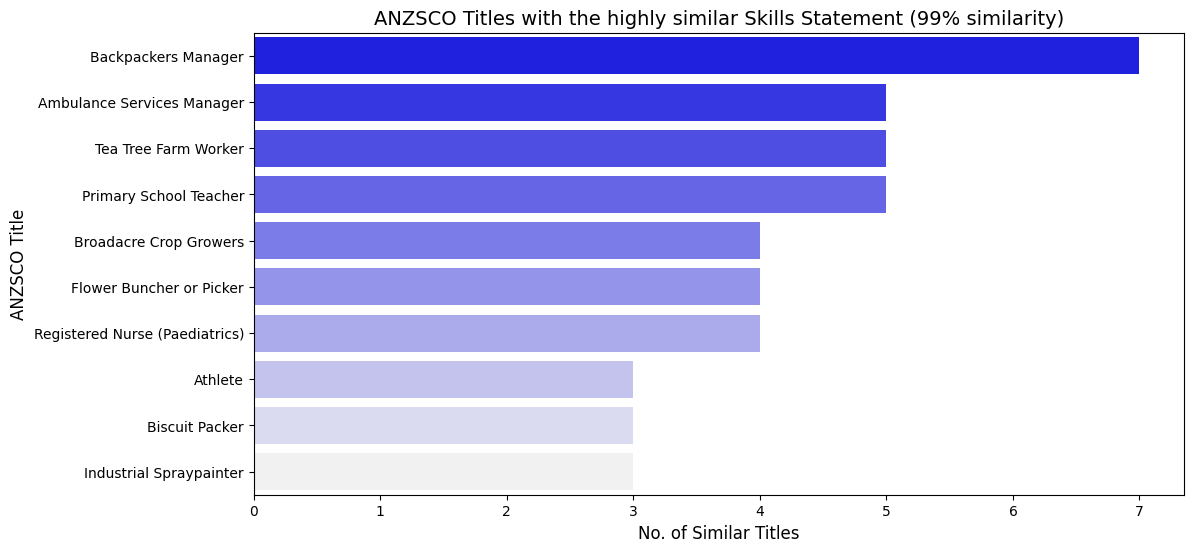

In [77]:
# Convert sorted titles list to DataFrame
df_similarity_specialist0 = pd.DataFrame(sorted_titles_specialist, columns=['ANZSCO Title', 'Similarity Count'])

# Filter to keep only the first occurrence of each processed title
df_similarity_specialist = df_similarity_specialist0[df_similarity_specialist0['ANZSCO Title'].isin(title_isolated_specialist)]

# Select the top 10 highest similarity counts
df_similarity_specialist = df_similarity_specialist.head(10)

# Divide 'Similarity Count' by 2 and ensure the result is an integer
df_similarity_specialist['Similarity Count'] = (df_similarity_specialist['Similarity Count'] / 2).astype(int)

# Create a red-to-light-red color palette
colors = sns.light_palette("blue", reverse=True, n_colors=len(df_similarity_specialist))

# Plot horizontal bar chart with the custom red-to-light-red palette
plt.figure(figsize=(12, 6))
sns.barplot(x='Similarity Count', y='ANZSCO Title', data=df_similarity_specialist, palette=colors)

# Title and labels
plt.title('ANZSCO Titles with the highly similar Skills Statement (99% similarity)', fontsize=14)
plt.xlabel('No. of Similar Titles', fontsize=12)
plt.ylabel('ANZSCO Title', fontsize=12)

# Format x-axis to show integer values only
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

# Show the plot
plt.show()

In [78]:
merged_df_desc = pd.merge(df_similarity_specialist0, Occupation_descriptions[['ANZSCO Title', 'Occupation Type', 'ANZSCO Code', 'Sub-Profile Code']], on='ANZSCO Title', how='left')
merged_df_desc.head(10)

,ANZSCO Title,Similarity Count,Occupation Type,ANZSCO Code,Sub-Profile Code
0,Backpackers Manager,14,NEC Category Occupation,141999,N01
1,Guest House Manager,14,NEC Category Occupation,141999,N04
2,Hostel Manager,14,NEC Category Occupation,141999,N05
3,Hotel Service Manager,12,ANZSCO 6,431411,NaN
4,Hotel Service Managers,12,ANZSCO 4,4314,NaN
5,Hotel and Motel Managers,12,ANZSCO 4,1413,NaN
6,Hotel or Motel Manager,12,ANZSCO 6,141311,NaN
7,Ambulance Services Manager,10,NEC Category Occupation,139999,N02
8,Director of Pharmacy,10,NEC Category Occupation,134299,N01
9,Director of Physiotherapy Services,10,NEC Category Occupation,134299,N02


In [79]:
# Filter the rows where 'ANZSCO Code' is either 141999 or 139999
filtered_df = Occupation_descriptions[Occupation_descriptions['ANZSCO Code'].isin([141999, 139999])]

# Select only the 'ANZSCO Title' and 'ANZSCO Description' columns
filtered_df = filtered_df[['ANZSCO Code', 'ANZSCO Title', 'ANZSCO Description']]

filtered_df

,ANZSCO Code,ANZSCO Title,ANZSCO Description
391,139999,Airport Manager,Ensure the safe take-off and landing of commer...
392,139999,Ambulance Services Manager,"Plan, direct, or coordinate ambulance services..."
393,139999,Archbishop,Lead religious worship and perform other spiri...
394,139999,Bishop,Conduct religious worship and perform other sp...
395,139999,Harbour Master,"Plan, direct, or coordinate marine transportat..."
396,139999,Security Manager (Non-ICT),"Direct an organisation's security functions, i..."
397,139999,Specialist Managers nec,This occupation group covers Specialist Manage...
402,141999,Backpackers Manager,"Plan, direct, or coordinate activities of a ba..."
403,141999,Boarding House Manager,"Plan, direct, or coordinate activities of a bo..."
404,141999,Casino Duty Manager,Directly supervise and coordinate activities o...


A cursory analysis of the Technology Tools document revealed that the top tools identified in the ASC are project management software, business intelligence and decision support software, and accounting and financial management systems. These tools are commonly used in managerial or supervisory roles, suggesting a higher number of such positions in the list.

The word cloud analysis of the Occupation Descriptions document further supports this, as both manager and officer appeared among the most common job title terms.

In [80]:
concat_Tech = concatenate_by_group_same_row_u(Technology_tools, 'ANZSCO Title', ['Technology Tool'])
TechTool_tokens = extract_phrase(concat_Tech['Technology Tool'])

TechTool_counts = Counter(TechTool_tokens)

print("Top 10 Technology Tools:")
for tool, count in TechTool_counts.most_common(10):
    print(f"{tool}: {count}")
print()
print("Least Required Technology Tools:")
for tool, count in TechTool_counts.most_common()[-10:]:
    print(f"{tool}: {count}")

Top 10 Technology Tools:
Project management software: 439
Business intelligence and decision support software: 305
Accounting and financial management systems: 256
Patient management systems and electronic health records: 245
Statistical and data analysis software: 237
Graphics or photo imaging software: 229
GPS and navigation technologies: 188
Social media platforms: 183
Inventory management software: 160
Industrial control and automation software: 157

Least Required Technology Tools:
Medical image archival and storage systems: 7
Body composition and analysis technologies: 5
Athlete performance and injury monitoring software: 4
Motion analysis software: 4
Wearable devices: 4
Quantitative schedule and risk analysis software: 3
Industrial endoscopes: 3
Medical endoscopes: 2
Social media Platforms: 1
Scientific and medical instrument sterilisers: 1


### European Skills, Competences, Qualifications and Occupations (ESCO)

The ESCO dataset used in the study includes 3,039 unique jobs, each assigned a specific code, which can be classified under 426 different International Standard Classification of Occupations (ISCO) groups contained in the 'occupations_en' document. Additionally, the classification specifies 13,939 unique skills categorized under four reuse levels (i.e., cross-sector, sector-specific, occupation-specific, transversal) and two skill types (i.e., skill/competence or knowledge) in the 'skills_en' file. This scope is almost twice of the ASC jobs list (1,650 unique job titles).

These two files served as references for the 'occupationSkillRelations_en' document, which details the skills required for each identified job title. This document contains 129,004 unique combinations of job titles and required skills.

As previously mentioned, the skills were broadly grouped by the European Commission into language, digital competence, digital, green, research, and transversal skills, which were specified in the following files: "languageSkillsCollection_en," "digCompSkillsCollection_en," "digitalSkillsCollection_en," "greenSkillsCollection_en," "researchSkillsCollection_en," and "transversalSkillsCollection_en." A review of the relationship between the overall 'skills_en' file and the group files reveals that not all skills are classified into groups, and some skills are included in multiple groups.

A missing value analysis of the documents was also conducted. The process revealed that several rows were missing values in the 'altLabels,' 'hiddenLabels,' 'scopeNote,' and 'definition' columns. These missing values were understandable within the context of these columns, as they contain auxiliary information to further differentiate job titles. The 'description' column can serve as the primary source of information to specify job titles. In addition to these columns, blank values were also identified in the 'skillType' and 'reuseLevel' columns. Since these fields only provide supplemental information regarding the skills listed relevant to the job, they were ignored in the subsequent analysis

In [81]:
main = ['occupations_en', 'skills_en', 'occupationSkillRelations_en']

for df_name in main:
    df = dfs[df_name]

    # Print .info to display general information about the dataframe
    print(f"DataFrame: {df_name}")
    print(df.info())

    # Print missing value counts for each column
    print("Missing values per column:")
    print(df.isna().sum())
    print("\n" + "="*50 + "\n")

DataFrame: occupations_en
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3039 entries, 0 to 3038
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   conceptType              3039 non-null   object
 1   conceptUri               3039 non-null   object
 2   iscoGroup                3039 non-null   int64 
 3   preferredLabel           3039 non-null   object
 4   altLabels                3011 non-null   object
 5   hiddenLabels             8 non-null      object
 6   status                   3039 non-null   object
 7   modifiedDate             3039 non-null   object
 8   regulatedProfessionNote  3039 non-null   object
 9   scopeNote                307 non-null    object
 10  definition               8 non-null      object
 11  inScheme                 3039 non-null   object
 12  description              3039 non-null   object
 13  code                     3039 non-null   object
dtypes: int64(1), o

In [82]:
dfs['occupations_en'][['preferredLabel']].describe()

,preferredLabel
count,3039
unique,3039
top,technical director
freq,1


In [83]:
# Get the unique count of 'ANZSCO Code' and 'Occupation Type'
unique_ESCO_code = dfs['occupations_en'][['code']].nunique()
unique_iscoGroup =  dfs['occupations_en'][['iscoGroup']].nunique()

# Print the results
print(f"Unique ESCO Code Count: {unique_ESCO_code}")
print(f"Unique iscoGroup Count: {unique_iscoGroup}")

Unique ESCO Code Count: code    3039
dtype: int64
Unique iscoGroup Count: iscoGroup    426
dtype: int64


In [84]:
dfs['skills_en'][['preferredLabel', 'skillType', 'reuseLevel', 'description']].describe()

,preferredLabel,skillType,reuseLevel,description
count,13939,13934,13934,13939
unique,13939,2,4,13936
top,manage musical staff,skill/competence,sector-specific,Manage the daily operations of a cultural faci...
freq,1,10715,6655,2


In [85]:
name = ['languageSkillsCollection_en', 'digCompSkillsCollection_en', 'digitalSkillsCollection_en', 'greenSkillsCollection_en', 'transversalSkillsCollection_en', 'researchSkillsCollection_en']

for df_name in name:
    df = dfs[df_name]

    # Print .info to display general information about the dataframe
    print(f"DataFrame: {df_name}")
    print(df.info())

    # Print missing value counts for each column
    print("Missing values per column:")
    print(df.isna().sum())
    print("\n" + "="*50 + "\n")

DataFrame: languageSkillsCollection_en
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359 entries, 0 to 358
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   conceptType        359 non-null    object
 1   conceptUri         359 non-null    object
 2   skillType          359 non-null    object
 3   reuseLevel         359 non-null    object
 4   preferredLabel     359 non-null    object
 5   status             359 non-null    object
 6   altLabels          358 non-null    object
 7   description        359 non-null    object
 8   broaderConceptUri  359 non-null    object
 9   broaderConceptPT   359 non-null    object
dtypes: object(10)
memory usage: 28.2+ KB
None
Missing values per column:
conceptType          0
conceptUri           0
skillType            0
reuseLevel           0
preferredLabel       0
status               0
altLabels            1
description          0
broaderConceptUri    0
broaderConc

In [86]:
# Load the main skills file from dfs
skills_df = dfs['skills_en']

# Define skill collections and corresponding columns
collections = {
    "languageSkillsCollection_en": "language",
    "digCompSkillsCollection_en": "digital_competence",
    "digitalSkillsCollection_en": "digital_skills",
    "greenSkillsCollection_en": "green_skills",
    "researchSkillsCollection_en": "research",
    "transversalSkillsCollection_en" : "transversal"
}

# Ensure broaderConceptPT column exists in skills_df
if "broaderConceptPT" not in skills_df.columns:
    skills_df["broaderConceptPT"] = ""

# Loop through collections and update columns + broaderConceptPT
for key, column in collections.items():
    collection_df = dfs[key]  # Accessing the DataFrame from dfs

    # Ensure the category column exists in skills_df
    if column not in skills_df.columns:
        skills_df[column] = ""

    # Update type classification based on conceptUri match
    match_mask = skills_df["conceptUri"].isin(collection_df["conceptUri"])
    skills_df.loc[match_mask, column] = column

    # Update broaderConceptPT where conceptUri matches
    broader_concept_map = dict(zip(collection_df["conceptUri"], collection_df["broaderConceptPT"]))
    skills_df.loc[match_mask, "broaderConceptPT"] = skills_df.loc[match_mask, "conceptUri"].map(broader_concept_map)

# Concatenate all category columns into a single "type" column
skills_df["type"] = skills_df[list(collections.values())].apply(lambda x: ", ".join(x[x != ""]), axis=1)

# Drop the original category columns (optional)
skills_df = skills_df.drop(columns=list(collections.values()))

In [87]:
merged_df_ESCO = pd.merge(
    dfs['occupationSkillRelations_en'],  # The first DataFrame
    dfs['occupations_en'][['conceptUri', 'preferredLabel']],  # Columns to merge from the second DataFrame
    left_on='occupationUri',  # Column from the first DataFrame
    right_on='conceptUri',  # Column from the second DataFrame
    how='left'  # 'left' join to keep all rows from occupationSkillRelations_en
)

merged_df_ESCO = pd.merge(
    merged_df_ESCO,  # The DataFrame that already has merged occupation and occupations information
    skills_df[['conceptUri', 'conceptType', 'skillType', 'reuseLevel', 'preferredLabel', 'altLabels', 'description', 'type', 'broaderConceptPT']],  # Columns to merge from skills_en
    left_on='skillUri',  # Column from merged_df to match
    right_on='conceptUri',  # Column from skills_en to match
    how='left'  # Left join to keep all rows from merged_df
)

Both ASC and ESCO show similar distributions regarding the word count in their job titles (typically 2-3 words) and job descriptions (ranging from 20-40 words). The similarity may suggest that the authors of each classification considered these word counts to be appropriate for effectively differentiating jobs at both the titular and descriptive levels. This can indicate that these average word counts may be the sufficient level of detail needed to distinguish between jobs in terms of their titles and descriptions.

In [88]:
# Assuming word_count is a function that counts words in a string
dfs['occupations_en']['title_word_count'] = dfs['occupations_en']['preferredLabel'].apply(word_count)
dfs['occupations_en']['description_word_count'] = dfs['occupations_en']['description'].apply(word_count)

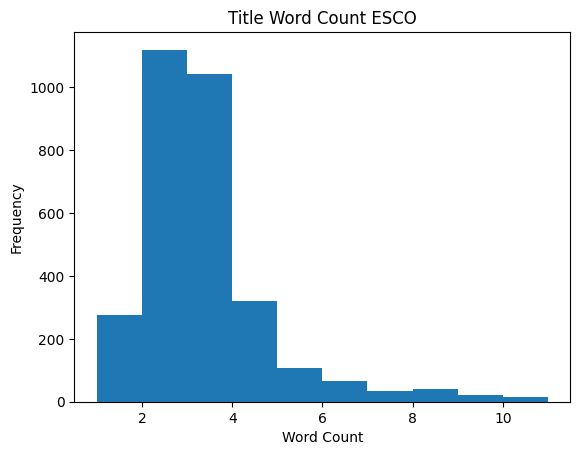

In [89]:
plt.hist(dfs['occupations_en']['title_word_count'], bins=10)
plt.title('Title Word Count ESCO')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

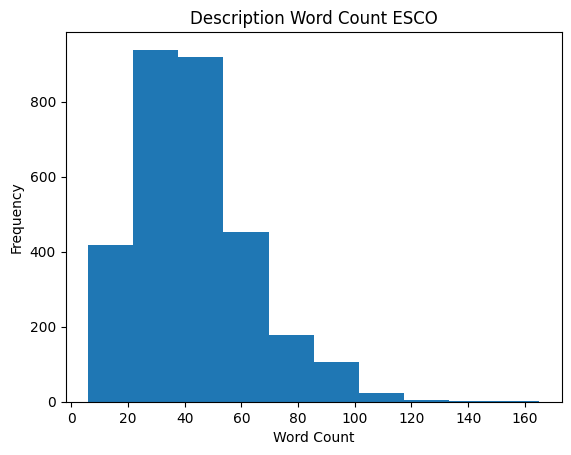

In [90]:
plt.hist(dfs['occupations_en']['description_word_count'], bins=10)
plt.title('Description Word Count ESCO')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

In [91]:
ESCOtitle = dfs['occupations_en']['preferredLabel'].to_string()
ESCOdescription = dfs['occupations_en']['description'].to_string()

The word cloud generated from the titles and descriptions of jobs listed in the ESCO document shows similarities with the ASC word cloud, especially in the most frequent words. Both datasets highlight terms like "managers" and "technicians" in the titles. However, ASC also includes "nec" (Not Elsewhere Classified) as one of the top words, which may suggest a broader or more generalized approach in ASC job titles, compared to the more specific titles found in ESCO.

Regarding the word cloud generated from the job descriptions, it appears that the ESCO job descriptions resemble the ESCO job titles more closely than the ASC job descriptions. This might suggest a differences as to how the jobs are described between ASC and ESCO. Notably, the ASC wordcloud for job descriptions includes more verbs, which could indicate a more action-oriented approach or a more consistent use of a group of verbs to describe the job.

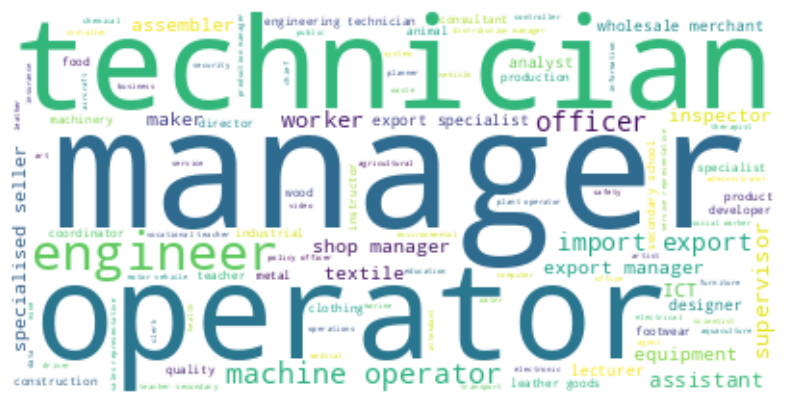

In [92]:
wordcloud_ESCO_title = WordCloud(max_words=100, background_color='white').generate(ESCOtitle)

# Create the plot
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_ESCO_title, interpolation='bilinear')  # Use imshow to display the word cloud
plt.axis('off')  # Turn off the axis
plt.show()  # Display the plot

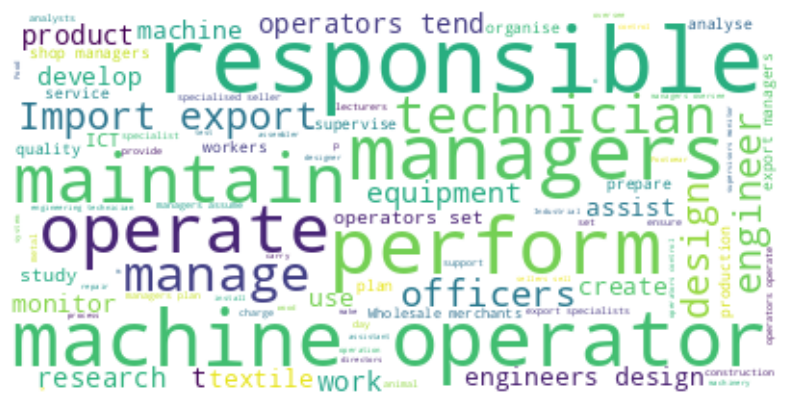

In [93]:
wordcloud_ESCO_desc = WordCloud(max_words=100, background_color='white').generate(ESCOdescription)

# Create the plot
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_ESCO_desc, interpolation='bilinear')  # Use imshow to display the word cloud
plt.axis('off')  # Turn off the axis
plt.show()  # Display the plot

The unique word percentage for the job descriptions in ESCO (8.33%) compared to ASC (12.19%) offers an interesting point of contrast. The lower percentage in ESCO suggests that the job descriptions may be more repetitive or a more standardized vocabulary was being implemented, potentially reflecting a more consistent or predefined way of describing jobs. However, it is important to consider that the total word count of the ESCO occupations_en job description is approximately three times that of the ASC job description, which could significantly influence this comparison.

When comparing the total unique words in the job titles, ESCO has 1,792 unique words, while ASC has 1,165. Despite ESCO having roughly double the number of job titles, the unique words used to label these jobs did not scale equally. This may suggest that, even with a larger set of jobs described, the diversity of words used to label the job does not increase at the same rate which shows the effectiveness of the words to provide appropriate summary to the job.

In [94]:
# Tokenize the descriptions and titles
ESCO_desc_token1 = dfs['occupations_en']['description'].apply(tokenize)
ESCO_title_token1 = dfs['occupations_en']['preferredLabel'].apply(tokenize)

# Create bigram model for descriptions
bigram = Phrases(ESCO_desc_token1, min_count=3, threshold=100)
bigram_model = Phraser(bigram)

# Apply function to remove stopwords for descriptions
tokenized_data_desc = [remove_stopword(text) for text in ESCO_desc_token1]

# Create bigrams for descriptions
bigram_data_desc = [create_bigrams(text) for text in tokenized_data_desc]

# Lemmatize the descriptions
lemmatized_data_desc = [lemmatize(text) for text in bigram_data_desc]

# Flatten all words into a single list for descriptions
all_desc_words = [word for text in lemmatized_data_desc for word in text]

# Compute total words and unique words in descriptions
total_desc_words = len(all_desc_words)
unique_desc_words = len(set(all_desc_words))

# Compute percentage of unique words in descriptions
desc_unique_pct = (unique_desc_words / total_desc_words) * 100 if total_desc_words > 0 else 0

# Print results for descriptions
print(f"Total Unique Description Word Count: {unique_desc_words}")
print(f"Total Words in Descriptions: {total_desc_words}")
print(f"Total Unique Description Word Percentage: {desc_unique_pct:.2f}%")

# Apply function to remove stopwords for titles
tokenized_data_title = [remove_stopword(text) for text in ESCO_title_token1]

# Create bigrams for titles
bigram_data_title = [create_bigrams(text) for text in tokenized_data_title]

# Lemmatize the titles
lemmatized_data_title = [lemmatize(text) for text in bigram_data_title]

# Flatten all words into a single list for titles
all_title_words = [word for text in lemmatized_data_title for word in text]

# Compute total words and unique words in titles
total_title_words = len(all_title_words)
unique_title_words = len(set(all_title_words))

# Compute percentage of unique words in titles
title_unique_pct = (unique_title_words / total_title_words) * 100 if total_title_words > 0 else 0

# Print results for titles
print(f"Total Unique Title Word Count: {unique_title_words}")
print(f"Total Words in Titles: {total_title_words}")
print(f"Total Unique Title Word Percentage: {title_unique_pct:.2f}%")


Total Unique Description Word Count: 6319
Total Words in Descriptions: 75854
Total Unique Description Word Percentage: 8.33%
Total Unique Title Word Count: 1792
Total Words in Titles: 7215
Total Unique Title Word Percentage: 24.84%


## Clustering/Topic Modelling



### Australian Skills Clssification

Taking into account the noted weakness of a single document analysis, the description, technology tool, core competency, specialist task, were combined to create a more holistic description of the job title. The resulting document is then used as the basis for the topic modelling and clustering.

In [95]:
# Merge the DataFrames on 'ANZSCO Title'
combined_df = pd.merge(Occupation_descriptions, concat_Tech, on='ANZSCO Title', how='left')
combined_df = pd.merge(combined_df, CC_comb, on='ANZSCO Title', how='left')
combined_df = pd.merge(combined_df, concat_Specialist, on='ANZSCO Title', how='left')

In [96]:
# Replace NaN values with blank strings in the specified columns
combined_df[['ANZSCO Description', 'Technology Tool', 'Specialist Task', 'Anchor Value']] = combined_df[['ANZSCO Description', 'Technology Tool', 'Specialist Task', 'Anchor Value']].fillna('')

# Now proceed with the concatenation
combined_df1 = concatenate_by_group_same_row(combined_df, 'ANZSCO Title', ['ANZSCO Description', 'Technology Tool', 'Specialist Task', 'Anchor Value'])

combined_df1 = pd.merge(combined_df1, Occupation_descriptions[['ANZSCO Title', 'Occupation Type', 'ANZSCO Code', 'Sub-Profile Code']], on='ANZSCO Title', how='left')
combined_df1.head(5)

,ANZSCO Title,concatenated,Occupation Type,ANZSCO Code,Sub-Profile Code
0,Abalone Diver,Commercially harvests abalone from underwater ...,Specialisation,399911,S01
1,Abattoir Manager,Directly supervise and coordinate the activiti...,NEC Category Occupation,149999,N01
2,Aboriginal Education Teacher,Support and teaches the learning outcomes of A...,NEC Category Occupation,241599,N01
3,Aboriginal Education Worker Coordinator,Support Aboriginal and Torres Strait Islander ...,Specialisation,422111,S05
4,Aboriginal Health Nurse,"Provides nursing care to individuals, families...",NEC Category Occupation,254499,N08


A topic list was extracted using Latent Dirichlet Allocation (LDA) from the combined document. However, after generating 10 topics and excluding words that appear in 90% or more of all documents, only three topics could be clearly distinguished:

1. Topic 5, linked to healthcare
2. Topic 7, associated with education
3. Topic 10, related to specialist tasks

In [97]:
tokenized_data = combined_df1["concatenated"].apply(tokenize)

# Apply function to remove the stopwords
tokenized_data_doc = [remove_stopword(text) for text in tokenized_data]

# Create the bigrams
bigram_data_doc = [create_bigrams(text) for text in tokenized_data_doc]

# Lemmatize the text
lemmatized_data_doc = [lemmatize(text) for text in bigram_data_doc]

# Create a dictionary
dictionary = Dictionary(lemmatized_data_doc)
dictionary.filter_extremes(no_above=0.9)
corpus = [dictionary.doc2bow(text) for text in lemmatized_data_doc]
lda_model = LdaModel(
   corpus=corpus, id2word=dictionary, num_topics=10,
   random_state=100, update_every=1, chunksize=100,
   passes=10, alpha=0.01, eta=0.01, per_word_topics=True
)
lda_model.save("lda_model")
del lda_model
lda_model = LdaModel.load("lda_model")

# Enable the display of visualizations in IPython Notebooks
pyLDAvis.enable_notebook()

# Prepare and transform and LDA model
pyLDAvis_data = prepare(lda_model, corpus, dictionary)
pyLDAvis.display(pyLDAvis_data)

By analyzing the elbow and silhouette results for different cluster sizes, it was observed that multiple elbow points could be considered. However, the highest silhouette score was achieved when only two clusters were selected. To ensure a more meaningful clustering approach, six clusters were chosen for the K-means model. This selection represents one of the potential elbow points while also maintaining the second-highest silhouette value, balancing interpretability and cluster quality.

In [98]:
def plot_elbow_method(X):
    sse = []
    k_range = range(2, 10)
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        sse.append(kmeans.inertia_)
    plt.figure()
    plt.plot(k_range, sse, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Sum of squared distances')
    plt.title('Elbow Method')
    plt.show()

def plot_silhouette_method(X):
    silhouette_avg_scores = []
    k_range = range(2, 10)
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        labels = kmeans.labels_
        silhouette_avg = silhouette_score(X, labels)
        silhouette_avg_scores.append(silhouette_avg)
    plt.figure()
    plt.plot(k_range, silhouette_avg_scores, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Method')
    plt.show()

In [99]:
vectorizer = TfidfVectorizer()
tfidf_matrix_ASC = vectorizer.fit_transform(combined_df1["concatenated"])

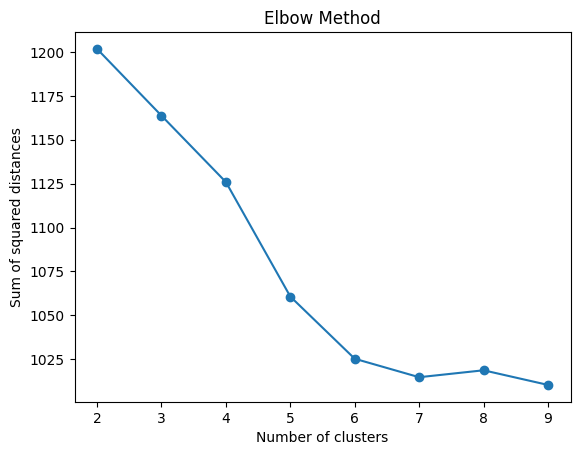

In [100]:
plot_elbow_method(tfidf_matrix_ASC)

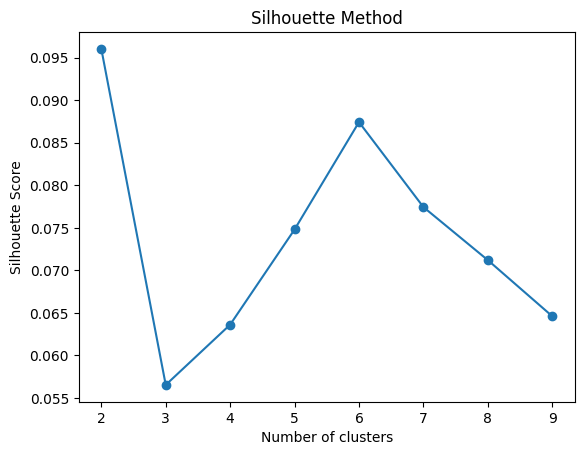

In [101]:
plot_silhouette_method(tfidf_matrix_ASC)

In [102]:
num_clusters = 6

In [103]:
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(tfidf_matrix_ASC)
labels = kmeans.labels_

The related topics for each cluster were loosely identified based on associated job titles and the most frequent bigrams and trigrams:

- Cluster 0: Agricultural and nature-based work
- Cluster 1: Business, sales, and marketing-related work
- Cluster 2: Health-related work
- Cluster 3: Customer-facing roles and machinery operation
- Cluster 4: Jobs involving end-to-end work processes
- Cluster 5: Miscellaneous roles (not elsewhere classified)

However, the resulting clusters are not well-defined, as observed in the scatterplot. While Clusters 0, 2, and 5 show clearer separation, the remaining clusters exhibit significant overlap. This raises concerns about the reliability of these clusters as a classification reference, suggesting potential limitations in the clustering approach or feature selection. Additionally, the overlap may indicate that the vocabulary used throughout the ASC document is too commonly shared across different job roles, making it difficult to distinguish between them effectively.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


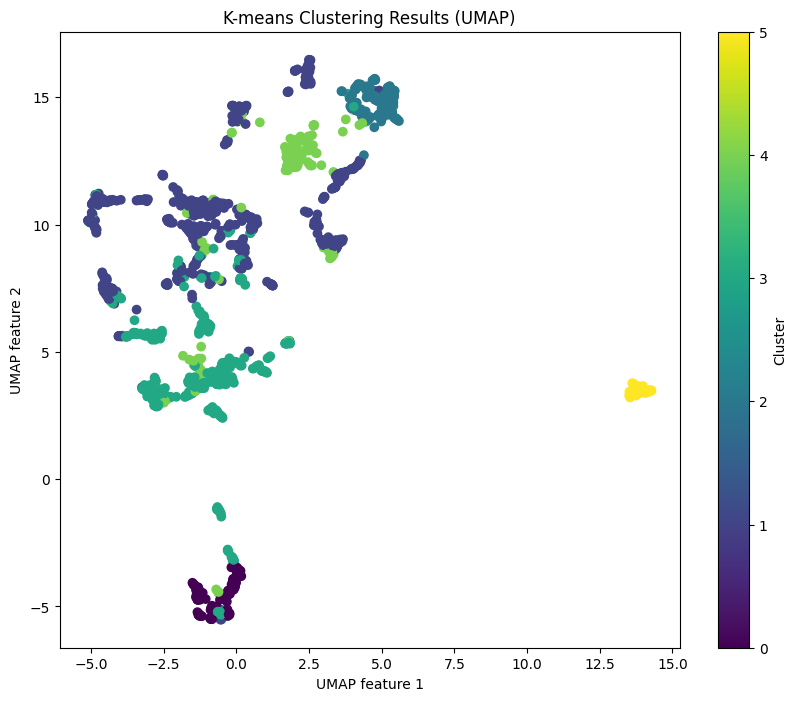


Cluster 0:
Senior Dairy Cattle Farm Worker, Fruit Farm Worker, Senior Livestock Farm Workers, Fruit Picker, Aquaculture Workers

Cluster 1:
Financial Brokers, Network Analyst, Casting Director, Grief Counsellor, Welfare Worker

Cluster 2:
Nurse Practitioner, Obstetrician and Gynaecologist, Chiropractors and Osteopaths, Cardiothoracic Surgeon, Radiology Nurse

Cluster 3:
Crane Chaser, Photographer's Assistant, Laundry Worker (General), Chemical, Gas, Petroleum and Power Generation Plant Operators, Telecommunications Cable Jointer

Cluster 4:
Stores Despatch Hand, Asthma Educator, Paediatric Thoracic Physician, Casino Gaming Inspector, Railway Signal Electrician

Cluster 5:
Cleaners nec, Actors, Dancers and Other Entertainers nec, Performing Arts Technicians nec, Film, Television, Radio and Stage Directors nec, Mobile Plant Operators nec


In [104]:
# Reduce dimensionality using UMAP
umap = UMAP(n_components=2, random_state=42)
X_umap = umap.fit_transform(tfidf_matrix_ASC)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=kmeans.labels_, cmap='viridis')
plt.title('K-means Clustering Results (UMAP)')
plt.xlabel('UMAP feature 1')
plt.ylabel('UMAP feature 2')
plt.colorbar(scatter, label='Cluster')
plt.show()

# Step 1: Assign Cluster Labels to the Original DataFrame
combined_df1['Cluster'] = kmeans.labels_

# Step 2: Group by Cluster to See ANZSCO Titles in Each Cluster
cluster_titles = combined_df1.groupby('Cluster')['ANZSCO Title'].apply(list)

# Step 3: Print or Analyze the Titles in Each Cluster
for cluster, titles in cluster_titles.items():
    print(f"\nCluster {cluster}:")
    print(", ".join(random.sample(titles, min(5, len(titles)))))


In [112]:
cluster_token_dict = {}

# Assuming combined_df1 contains your data and 'Cluster' column has cluster labels
for cluster in sorted(combined_df1['Cluster'].unique()):
    # Filter data for the current cluster
    cluster_data = combined_df1[combined_df1['Cluster'] == cluster]

    tokenized_data = cluster_data['concatenated'].apply(tokenize).tolist()

    # Store the tokenized data in the dictionary
    cluster_token_dict[cluster] = tokenized_data

    # Apply function to remove stopwords
    tokenized_data_desc = [remove_stopword(text) for text in tokenized_data]

    # Create the bigrams
    bigram_data_desc = [create_bigrams(text) for text in tokenized_data_desc]

    # Lemmatize the text
    lemmatized_data_desc = [lemmatize(text) for text in bigram_data_desc]

    # Flatten the list of tokens
    flattened_text = [token for sublist in lemmatized_data_desc for token in sublist]

    # Get top trigrams
    top_trigrams = get_top_ngrams(flattened_text, 3, 10)

    # Print the results
    print(f"\nTop 10 Trigrams: Cluster {cluster}")
    for trigram, count in top_trigrams:
        print(f"{' '.join(trigram)}: {count}")


Top 10 Trigrams: Cluster 0
forestry hunt agricultural: 164
hunt agricultural equipment: 164
operate forestry hunt: 87
maintain forestry hunt: 77
perform manual agricultural: 76
manual agricultural aquacultural: 76
agricultural aquacultural horticultural: 76
aquacultural horticultural task: 76
agricultural forestry product: 64
plant crop tree: 64

Top 10 Trigrams: Cluster 1
negotiate price sale: 294
price sale term: 294
sale term prepare: 290
read book lead: 288
book lead manage: 288
lead manage change: 288
manage change diverse: 288
change diverse evolve: 288
diverse evolve workplace: 288
project management software: 287

Top 10 Trigrams: Cluster 2
patient management system: 161
management system electronic: 161
system electronic health: 161
electronic health record: 161
collect record store: 141
record store patient: 141
store patient medical: 141
collaborate health care: 130
health care professional: 130
care professional plan: 130

Top 10 Trigrams: Cluster 3
answer customer questio

### ESCO

A topic list was extracted using Latent Dirichlet Allocation (LDA) from the combined ESCO document. After generating 10 topics and excluding words that appear in 90% or more of all documents, around seven (7) topics could be distinguished.

1. Topic 1, associated with safety
2. Topic 2, customer-centric terms
3. Topic 3, processing materials
4. Topic 4, engineering-based words
5. Topic 8, data/information
6. Topic 9, creatives
7. Topic 10, computers/technology

This delineates more topics compared to the ASC document.

In [113]:
merged_df_ESCO = pd.merge(
    dfs['occupationSkillRelations_en'],  # The first DataFrame
    dfs['occupations_en'][['conceptUri', 'preferredLabel']],  # Columns to merge from the second DataFrame
    left_on='occupationUri',  # Column from the first DataFrame
    right_on='conceptUri',  # Column from the second DataFrame
    how='left'  # 'left' join to keep all rows from occupationSkillRelations_en
)

merged_df_ESCO = pd.merge(
    merged_df_ESCO,  # The DataFrame that already has merged occupation and occupations information
    skills_df[['conceptUri', 'conceptType', 'skillType', 'reuseLevel', 'preferredLabel', 'altLabels', 'description', 'type', 'broaderConceptPT']],  # Columns to merge from skills_en
    left_on='skillUri',  # Column from merged_df to match
    right_on='conceptUri',  # Column from skills_en to match
    how='left'  # Left join to keep all rows from merged_df
)

In [114]:
concat_ESCO = concatenate_by_group_same_row(merged_df_ESCO, 'preferredLabel_x', ['description'])

In [115]:
tokenized_data_ESCO = concat_ESCO["concatenated"].apply(tokenize)
tokenized_data_desc_ESCO = [remove_stopword(text) for text in tokenized_data_ESCO]
bigram_data_desc_ESCO = [create_bigrams(text) for text in tokenized_data_desc_ESCO]
lemmatized_data_desc_ESCO = [lemmatize(text) for text in bigram_data_desc_ESCO]
flattened_text_ESCO = [token for sublist in lemmatized_data_desc_ESCO for token in sublist]

In [116]:
# Create a dictionary
dictionary = Dictionary(lemmatized_data_desc_ESCO)
dictionary.filter_extremes(no_above=0.9)
corpus = [dictionary.doc2bow(text) for text in lemmatized_data_desc_ESCO]
lda_model = LdaModel(
   corpus=corpus, id2word=dictionary, num_topics=10,
   random_state=100, update_every=1, chunksize=100,
   passes=10, alpha=0.01, eta=0.01, per_word_topics=True
)
lda_model.save("lda_model")
del lda_model
lda_model = LdaModel.load("lda_model")

# Enable the display of visualizations in IPython Notebooks
pyLDAvis.enable_notebook()

# Prepare and transform and LDA model
pyLDAvis_data = prepare(lda_model, corpus, dictionary)
pyLDAvis.display(pyLDAvis_data)

In [117]:
merged_df_ESCO = merged_df_ESCO.replace("\n", " ", regex=True)

In [118]:
dfs['occupations_en'] = dfs['occupations_en'].replace("\n", " ", regex=True)

In [119]:
ESCO_doc = pd.merge(
    dfs['occupations_en'],
    concat_ESCO[['preferredLabel_x', 'concatenated']],
    left_on='preferredLabel',
    right_on='preferredLabel_x',
    how='right'
)

ESCO_clean = concatenate_by_group_same_row(ESCO_doc, 'preferredLabel_x', ['description', 'concatenated'])
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(ESCO_clean['concatenated'].dropna())

K-means clustering was applied to the ESCO document, and an analysis of the elbow method and silhouette scores for different cluster sizes was conducted to determine the optimal number of clusters. While multiple elbow candidates were observed, the number of clusters with the highest silhouette score was selected as the optimal choice (7).

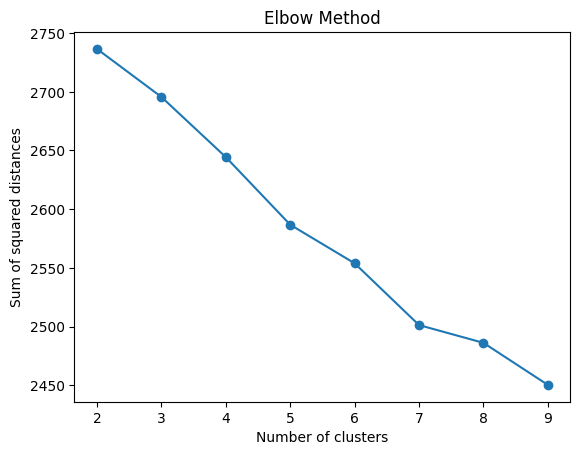

In [120]:
plot_elbow_method(tfidf_matrix)

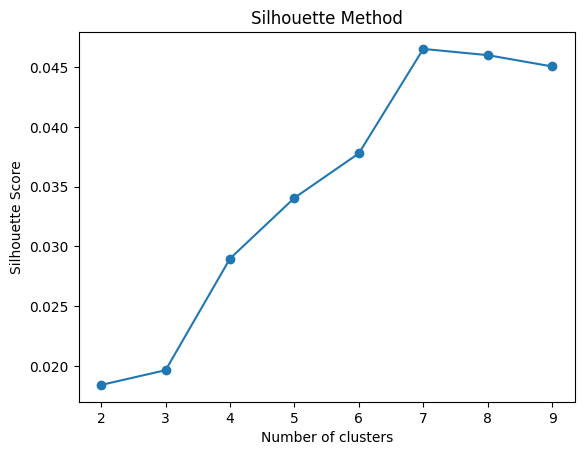

In [121]:
plot_silhouette_method(tfidf_matrix)

Similar to the ASC clustering, the related topics for the seven cluster were loosely identified based on associated job titles and the most frequent bigrams and trigrams, as follows:

- Cluster 0: jobs that deal with food safety
- Cluster 1: jobs that deal with machines/tools
- Cluster 2: jobs that deal with health
- Cluster 3: jobs that deal with legal/license/regulatory requirements
- Cluster 4: jobs that deal with education
- Cluster 5: jobs that deal with technology
- Cluster 6: jobs that provide social/professional services

Similar to the ASC clusters, majority of the ESCO clusters are not clearly defined in the scatterplot which also puts into question its actual useability for classification of the jobs.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


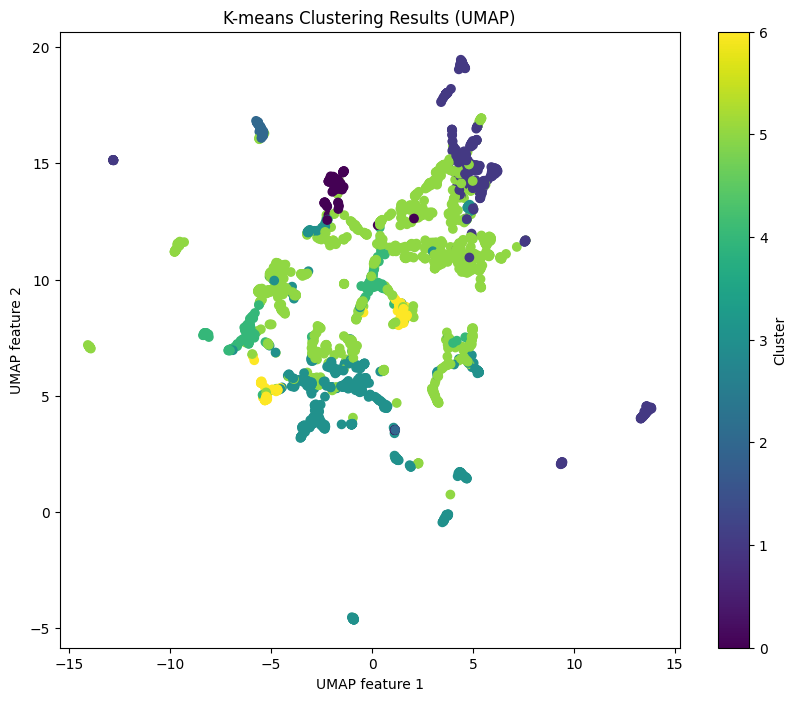

In [122]:
num_clusters = 7

kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(tfidf_matrix)

# Reduce dimensionality using UMAP
umap = UMAP(n_components=2, random_state=42)
X_umap = umap.fit_transform(tfidf_matrix)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=kmeans.labels_, cmap='viridis')
plt.title('K-means Clustering Results (UMAP)')
plt.xlabel('UMAP feature 1')
plt.ylabel('UMAP feature 2')
plt.colorbar(scatter, label='Cluster')
plt.show()

In [123]:
# Step 1: Assign Cluster Labels to the Original DataFrame
ESCO_clean['Cluster'] = kmeans.labels_

# Step 2: Group by Cluster to See ANZSCO Titles in Each Cluster
cluster_titles = ESCO_clean.groupby('Cluster')['preferredLabel_x'].apply(list)

# Step 3: Print or Analyze the Titles in Each Cluster
for cluster, titles in cluster_titles.items():
    print(f"\nCluster {cluster}:")
    print(", ".join(random.sample(titles, min(5, len(titles)))))


Cluster 0:
food production engineer, fish preparation operator, chilling operator, kitchen assistant, beer sommelier

Cluster 1:
canvas goods assembler, leather goods artisanal worker, textile designer, footwear factory warehouse operator, clothing operations manager

Cluster 2:
dog breeder, live animal transporter, animal artificial insemination technician, veterinary nurse, dog trainer

Cluster 3:
import export specialist in coffee, tea, cocoa and spices, education administrator, advertising media planner, political affairs officer, delicatessen shop manager

Cluster 4:
music instructor, head of higher education institutions, microbiologist, mineralogist, language school teacher

Cluster 5:
club host/club hostess, promoter, material testing technician, transport health and safety inspector, vineyard supervisor

Cluster 6:
dance therapist, medical records clerk, migrant social worker, herbal therapist, healthcare consultant


In [124]:
# Define a list of clusters
clusters = range(7)  # Assuming clusters are from 0 to 7

# Loop through each cluster
for cluster in clusters:
    # Create a new column for each cluster's tokenized data
    cluster_name = f"ESCO_{cluster}_token"
    ESCO_clean_cluster = ESCO_clean[ESCO_clean['Cluster'] == cluster]

    # Apply the tokenize function to the 'concatenated' column
    globals()[cluster_name] = ESCO_clean_cluster["concatenated"].apply(tokenize)

In [125]:
clusters = range(7)

for cluster in clusters:
    # Get the tokenized data for the current cluster
    tokenized_data = globals().get(f'ESCO_{cluster}_token')  # Dynamically access cluster variables

    # Apply function to remove stopwords
    tokenized_data_desc = [remove_stopword(text) for text in tokenized_data]

    # Create the bigrams
    bigram_data_desc = [create_bigrams(text) for text in tokenized_data_desc]

    # Lemmatize the text
    lemmatized_data_desc = [lemmatize(text) for text in bigram_data_desc]

    # Flatten the list of tokens
    flattened_text = [token for sublist in lemmatized_data_desc for token in sublist]

    # Get top trigrams
    top_trigrams = get_top_ngrams(flattened_text, 3, 10)

    # Print the results
    print(f"\nTop 10 Trigrams: Cluster {cluster}")
    for trigram, count in top_trigrams:
        print(f"{' '.join(trigram)}: {count}")


Top 10 Trigrams: Cluster 0
food safety procedure: 213
food food safety: 205
apply regulation regard: 204
regulation regard manufacture: 204
regard manufacture food: 204
manufacture food food: 204
food safety compliance: 204
safety compliance employ: 204
compliance employ food: 204
employ food safety: 204

Top 10 Trigrams: Cluster 1
machine machine tool: 329
monitor operate accord: 170
operate accord regulation: 170
product service process: 161
international requirement specification: 160
requirement specification guideline: 160
specification guideline ensure: 160
guideline ensure product: 160
ensure product service: 160
service process good: 160

Top 10 Trigrams: Cluster 2
transmission disease ensure: 75
plan use appropriate: 73
measure prevent transmission: 73
prevent transmission disease: 73
disease ensure effective: 73
ensure effective overall: 73
communicate site hygiene: 73
site hygiene control: 73
work animal include: 62
animal welfare need: 54

Top 10 Trigrams: Cluster 3
legal 

## Results and Discussion

**Strengths and Weakness of ASC**

When comparing the two classification systems, the strength of ASC lies in its consistent vocabulary across job descriptions, core competencies, and specializations, which enhances the document's relatability across different job titles. However, this consistency could also reduce the specificity within the job descriptions.

This becomes particularly evident in the topic modeling and clustering results, where the impact of "Not Elsewhere Classified" (NEC) jobs is clearly identified. These NEC jobs play a significant role in the actual delineation of the groups, highlighting potential challenges in maintaining clarity and precision when compared to a more expansive system like ESCO.

Furthermore, deliberate choices, such as creating unit groups with covers only one occupation code, currently present redundancies in the document, ultimately decreasing its overall readability. However, it can be noted that the identified similar job titles mostly belong under the same group, signifying that related job titles are mostly correctly grouped up making the current ASC job titles reliable in finding related jobs.

**Data Scientists Skills and AI**

Utilising the clusters formed from the classification documents to answer the question about data scientist skills, data scientists are required to be able to create advanced algorithms to analyse large datasets, retrieve information from the database, and possibly develop a software that can do these tasks. This description is highly in line with Australian Computer Society (ACS)'s description of a Data Scientist's employment duties, as follows:

- Prepares data for analysis, cleans data, and recognises and overcomes data anomalies
- Applies analytics techniques that incorporate mathematical, statistical, programming and database skills
- Builds and deploys machine learning and artificial intelligence frameworks
- Applies models to data, and evaluates and adjusts models to discover trends and extract insights
- Presents data-driven findings and outcomes to key decision-makers and stakeholders
- Provides strategic input and innovation to organisational data science initiatives

In order to do so, Data Scientists might be required to utilize a programming language (e.g., Python), data processing engine (e.g., Snowflake), and visualization tools (e.g., PowerBI/Tableau).

With the introduction of Artificial Intelligence (AI) tools that can automatically generate code based on user instructions (e.g., GitHub Copilot and ChatGPT), the skill demand is slowly being shifted from hard coding ability to proofing generated code. In this topic, A survey conducted by Chen et al. (2024) aimed to capture the impact of GenAI code generation tools in the software engineering industry. According to the survey respondents, most software engineers are highly aware of GenAI tools. However, the lack of unified standards in their usage exposes the industry to challenges in assessing the actual skills of potential new recruits, which could lead to avoidable issues once the limitations of GenAI are encountered during real-world work. As such, the development of curricula to help students develop proficiency in AI tools, based on common industry use cases, is essential to help the field transition into the AI-augmented future of software engineering.

With AI's capacity to assist in automating relatively simple tasks, like coding basic data analysis and visualizations, foundational knowledge in data science techniques and tools becomes even more critical. Users must be able to understand the logic behind the code and correct any generated lines that might not accurately reflect the applied methodology. (Knight, 2024)

To conclude, AI tools undoubtedly offer efficiencies in the data science and analysis process, particularly in automating certain aspects of coding. Nonetheless, Data Scientists are still required to utilize their expertise in validating the output of these tools to ensure that the correct processes are being followed.

In [126]:
data_scientist_info_ASC = combined_df1[combined_df1['ANZSCO Title'].str.title() == 'Data Scientist']

# Tokenize the 'ANZSCO Title' for 'Data Scientist'
tokenized_data_title = [tokenize(text) for text in data_scientist_info_ASC['concatenated']]

# Apply function to remove the stopwords
tokenized_data_title = [remove_stopword(text) for text in tokenized_data_title]

# Create the bigrams
bigram_data_title = [create_bigrams(text) for text in tokenized_data_title]

# Lemmatize the text
lemmatized_data_title = [lemmatize(text) for text in bigram_data_title]

# Flatten the list of tokens
flattened_title_text = [token for sublist in lemmatized_data_title for token in sublist]

# Get top trigrams from the 'Data Scientist' titles
top_trigrams_title = get_top_ngrams(flattened_title_text, 3, 10)

# Print the results for trigrams in 'Data Scientist' titles
print("\nTop 10 Trigrams for Data Scientist Titles:")
for trigram, count in top_trigrams_title:
    print(f"{' '.join(trigram)}: {count}")


Top 10 Trigrams for Data Scientist Titles:
apply analytical technique: 1
analytical technique scientific: 1
technique scientific procedure: 1
scientific procedure large: 1
procedure large dataset: 1
large dataset create: 1
dataset create advanced: 1
create advanced algorithm: 1
advanced algorithm datum: 1
algorithm datum model: 1


In [127]:
# Filter the data for "Data Scientist"
data_scientist_info = ESCO_clean[ESCO_clean['preferredLabel_x'].str.lower() == 'data scientist']

# Tokenize the descriptions of the data scientist jobs
tokenized_data_desc = [tokenize(text) for text in data_scientist_info['concatenated']]

# Apply function to remove the stopwords
tokenized_data_desc = [remove_stopword(text) for text in tokenized_data_desc]

# Create the bigrams
bigram_data_desc = [create_bigrams(text) for text in tokenized_data_desc]

# Lemmatize the text
lemmatized_data_desc = [lemmatize(text) for text in bigram_data_desc]

# Flatten the list of tokens
flattened_text = [token for sublist in lemmatized_data_desc for token in sublist]

# Get top trigrams
top_trigrams = get_top_ngrams(flattened_text, 3, 10)

# Print the results for trigrams
print("\nTop 10 Trigrams for Data Scientist:")
for trigram, count in top_trigrams:
    print(f"{' '.join(trigram)}: {count}")


Top 10 Trigrams for Data Scientist:
language retrieval information: 7
retrieval information database: 7
information database document: 7
database document contain: 7
document contain needed: 7
contain needed information: 7
needed information develop: 5
information develop software: 3
develop software company: 3
computer language language: 3


# Acknowledgements and References

## Acknowledgements




This documents includes content of the Australian Skills Classification by Jobs and Skills Australia, Commonwealth of Australia. Used under CC BY 4.0 license.

Some of the code utilised in the analysis were generated using AI (ChatGPT).


## References

- OpenAI. (2025). https://chat.openai.com/
- Australian Computer Society. (n.d.). Data science occupations and ANZSCO codes. Australian Computer Society. https://www.acs.org.au/msa/information-for-applicants/occupations-anzsco-codes/data-science.html
- Chen, A., Huo, T., Nam, Y., Port, D., & Peruma, A. (2024). The impact of generative AI-powered code generation tools on software engineer hiring: Recruiters' experiences, perceptions, and strategies. https://doi.org/10.48550/arXiv.2409.00875
- Knight, M. (2024). The impact of generative AI on data science. Dataversity. https://www.dataversity.net/the-impact-of-generative-ai-on-data-science